In [1]:
import sys
# sys.path.append(r"Y:\Users\Yingyue\Gates_Lab_Suite-master")
sys.path.append(r"/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master")
from Core_Definition import *
from Auto_Algorithm import *
from Visualization import *
import os
from SPAM import *
import numpy as np
import xlsxwriter as xlsx
from scipy import optimize
import random
import math
from math import floor
import pickle
import uuid

In [2]:
import json, pickle
import qiskit
#transpiler reducinig qiskit circuit to QASM strings
from qiskit import transpile
# Use AerSimulator
from qiskit_aer import AerSimulator
from qiskit import IBMQ, QuantumCircuit, execute
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info import Pauli, Clifford, Statevector,Operator
from qiskit.visualization import array_to_latex
from scipy.stats import sem, unitary_group
from scipy.linalg import sqrtm,expm
import qiskit.quantum_info as qi
from qiskit.quantum_info import Pauli
import pylatexenc

In [3]:
def state_init_bell_pairs(qc,n):
    for i in range (n):
        qc.Add_Gate(Quantum_Gate("HAD",i))
    for i in range (n):
        qc.Add_Gate(Quantum_Gate("CNOT",i,int(i+n)))

        
#should we set_mapping in this function? need to think about if it takes mapping into account   
def add_pauli_twirl(qc,n):
    pauliLayer = [random.choice(['I','X','Y','Z']) for j in range(n)]
    q_index=0
    for pauli in pauliLayer :
        if (pauli=="I"):
            qc.Add_Gate(Quantum_Gate("SKAX",2*n,angle=1))
        elif (pauli=="X"):
            qc.Add_Gate(Quantum_Gate("SKAX",q_index,angle=1))
        elif (pauli=="Y"):
            qc.Add_Gate(Quantum_Gate("SKAY",q_index,angle=1))
        elif (pauli=="Z"):
            qc.Add_Gate(Quantum_Gate("AZ",q_index,angle=1))
        q_index+=1
    return pauliLayer

def add_pauli_twirl_wSE(qc,n):
    pauliLayer = [random.choice(['I','X','Y','Z']) for j in range(n)]
    q_index=0
    for pauli in pauliLayer :
        if (pauli=="I"):
            qc.Add_Gate(Quantum_Gate("SKAX",2*n,angle=1))
        elif (pauli=="X"):
            qc.Add_Gate(Quantum_Gate("SKAX",q_index,angle=1))
        elif (pauli=="Y"):
            qc.Add_Gate(Quantum_Gate("SKAY",q_index,angle=1))
        elif (pauli=="Z"):
            qc.Add_Gate(Quantum_Gate("AZ",q_index,angle=1))
        
        if (q_index==(int(n/2)-1)):
            for i in range (n):
                qc.Add_Gate(Quantum_Gate("SKAX",n+i,angle=1))
        q_index+=1
    return pauliLayer
    
def add_clifford_layer(qc,n,clifford):
    if (clifford=="CNOT"):
        for i in range (floor(n/2)):
            qc.Add_Gate(Quantum_Gate("CNOT",2*i,2*i+1))
            
def bell_measurement(qc,n):
    for i in range (n-1,-1,-1):
        qc.Add_Gate(Quantum_Gate("SKAX",int(i+n),angle=1))
        qc.Add_Gate(Quantum_Gate("CNOT",i,int(i+n)))
    for i in range (n-1,-1,-1):
        qc.Add_Gate(Quantum_Gate("HAD",i))

def map_statepop_2_ibm_mapping(counts,n):
    counts_ibm_mapping=[0 for i in range (2**(2*n))]
    idx_ibm_mapping=[]
    counts_ibm_mapping_dic={}
    if len(str((2*n)))<2:
        f="00"+str(2*n)+"b"
    elif len(str((2*n)))<3:
        f="0"+str(2*n)+"b"
    else:
        raise ValueError("n is too big")
    for gates_idx in range (2**(2*n)):
        gates_idx_str=format(gates_idx,f)
        ibm_idx=0
        for i in range (2*n):
            ibm_idx+=2**(i)*int(gates_idx_str[i])
        ibm_idx_str=format(ibm_idx,f)
#         idx_ibm_mapping.append(ibm_idx_str)
        counts_ibm_mapping[ibm_idx]=counts[gates_idx]
        counts_ibm_mapping_dic[ibm_idx_str]=counts[gates_idx]
    return counts_ibm_mapping, counts_ibm_mapping_dic
        
        
#for qiskit
def prepare_bell_state_1q(circuit,index1,index2):
	circuit.h([index1])
	circuit.cx([index1],[index2])
        
def bell_measurement_1q(circuit,index1,index2): 
	# info qubit at index1
	circuit.cx([index1],[index2])
	circuit.h([index1])

def pauli_gate_1q(circuit,index,pauli=None): #For stabilizer simulator to work, cannot use Pauli class
	if pauli == 'I':
		circuit.id([index])
	elif pauli == 'Z':
		circuit.z([index])
	elif pauli == 'X':
		circuit.x([index])
	elif pauli == 'Y':
		circuit.y([index])
	else:
		assert 1==0

    
    
    

In [4]:
## Additional functions

def int_to_pauli(i,n):
    p = np.base_repr(i,base=4)
    p = '0'*(n-len(p)) + p
    p = p.replace('0','I').replace('1', 'X').replace('2', 'Y').replace('3', 'Z')
    return p

def commute(p,q):
    c = 1
    n = len(p)
    for i in range(n):
        if p[i] != 'I' and q[i] != 'I':
            if p[i] != q[i]:
                c *= -1
    return c

def fidelity_to_error(pauli_fidelity,n):
    N = 4**n
    pauli_error = {}
    for i in range(N):
        p = int_to_pauli(i,n)
        pauli_error[p] = 0
        for j in range(N):
            q = int_to_pauli(j,n)
            pauli_error[p] += pauli_fidelity[q] * commute(p,q) / N
    return pauli_error
    

In [5]:
Set_Mapping([2,3,5,4,1])
nqubit=2
C=10
results_d2=np.zeros((C,2**(2*nqubit)))
results_d4=np.zeros((C,2**(2*nqubit)))
results_d8=np.zeros((C,2**(2*nqubit)))

file=open(r"/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/circuits/23541 EAB XX C=10 0424  set2/d=8.txt", 'r')
Lines= file.readlines()
c_d8=[]
count = 0
for line in Lines:
    c_d8.append(line)
    count += 1
print (count)
count=0

file=open(r"/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/circuits/23541 EAB XX C=10 0424  set2/d=4.txt", 'r')
Lines= file.readlines()
c_d4=[]
count = 0
for line in Lines:
    c_d4.append(line)
    count += 1
print (count)
count=0

file=open(r"/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/circuits/23541 EAB XX C=10 0424  set2/d=2.txt", 'r')
Lines= file.readlines()
c_d2=[]
count = 0
for line in Lines:
    c_d2.append(line)
    count += 1
print (count)
count=0


10
10
10


In [11]:
filenames_d2=[]
filenames_d4=[]
filenames_d8=[]
filenames=[]

paf_data_d2="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0426/2023-04-26 eab__d=2/"
L1=[]
filenames=[]
line_Idx="000"
line_num=""
p=0 #position indicator

#------------------------------------------read in raw data-------------------------------
for f in os.listdir(paf_data_d2):
    if (f.find("Line")!=-1):
        n=f.find("_")
        line_Idx=f[n+6:n+9]
        for i in range(3):
            if line_Idx[i]=="0":
                p+=1
            else:
                line_num=line_Idx[p:3]
                p=0
                break
        L1.append(int(line_num))
        filenames.append(f)
    else:
        print (f) #print out non datafiles just for debugging 
        continue
for Idx in range (len(filenames)):
    for i in range (len(filenames)):
        if L1[i]==Idx+1:
            filenames_d2.append(filenames[i])
            break
print (filenames_d2)

paf_data_d4="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0426/2023-04-26 eab__d=4/"
L1=[]
filenames=[]
line_Idx="000"
line_num=""
p=0 #position indicator

#------------------------------------------read in raw data-------------------------------
for f in os.listdir(paf_data_d4):
    if (f.find("Line")!=-1):
        n=f.find("_")
        line_Idx=f[n+6:n+9]
        for i in range(3):
            if line_Idx[i]=="0":
                p+=1
            else:
                line_num=line_Idx[p:3]
                p=0
                break
        L1.append(int(line_num))
        filenames.append(f)
    else:
        print (f) #print out non datafiles just for debugging 
        continue
for Idx in range (len(filenames)):
    for i in range (len(filenames)):
        if L1[i]==Idx+1:
            filenames_d4.append(filenames[i])
            break
print (filenames_d4)

paf_data_d8="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0426/2023-04-26 eab__d=8/"
L1=[]
filenames=[]
line_Idx="000"
line_num=""
p=0 #position indicator

#------------------------------------------read in raw data-------------------------------
for f in os.listdir(paf_data_d8 ):
    if (f.find("Line")!=-1):
        n=f.find("_")
        line_Idx=f[n+6:n+9]
        for i in range(3):
            if line_Idx[i]=="0":
                p+=1
            else:
                line_num=line_Idx[p:3]
                p=0
                break
        L1.append(int(line_num))
        filenames.append(f)
    else:
        print (f) #print out non datafiles just for debugging 
        continue
for Idx in range (len(filenames)):
    for i in range (len(filenames)):
        if L1[i]==Idx+1:
            filenames_d8.append(filenames[i])
            break
print (filenames_d8)

['2023-04-26-151421_Line_001.txt', '2023-04-26-151500_Line_002.txt', '2023-04-26-151540_Line_003.txt', '2023-04-26-151730_Line_004.txt', '2023-04-26-151809_Line_005.txt', '2023-04-26-151849_Line_006.txt', '2023-04-26-153218_Line_007.txt', '2023-04-26-153257_Line_008.txt', '2023-04-26-153336_Line_009.txt', '2023-04-26-153415_Line_010.txt']
['2023-04-26-153753_Line_001.txt', '2023-04-26-153839_Line_002.txt', '2023-04-26-154038_Line_003.txt', '2023-04-26-154123_Line_004.txt', '2023-04-26-154319_Line_005.txt', '2023-04-26-154405_Line_006.txt', '2023-04-26-154602_Line_007.txt', '2023-04-26-154646_Line_008.txt', '2023-04-26-162116_Line_009.txt', '2023-04-26-162203_Line_010.txt']
archive
['2023-04-26-164507_Line_001.txt', '2023-04-26-164609_Line_002.txt', '2023-04-26-164825_Line_003.txt', '2023-04-26-164925_Line_004.txt', '2023-04-26-165139_Line_005.txt', '2023-04-26-165239_Line_006.txt', '2023-04-26-170327_Line_007.txt', '2023-04-26-170429_Line_008.txt', '2023-04-26-170745_Line_009.txt', '20

In [7]:
a=Quantum_State(5)
a_s=Quantum_State(5)
b_c=Quantum_Circuit(5,"qc")

spam1=SPAM_Operator(5)
spam1.Import("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0424/SPAM1/SPAM1.csv")

spam2=SPAM_Operator(5)
spam2.Import("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0424/SPAM1/SPAM1.csv")


2023-04-26-151421_Line_001.txt
counts: [77, 2931, 158, 100, 84, 206, 18, 21, 10, 195, 94, 44, 5, 32, 14, 11]
counts_ibm_mapping_dic: {'0000': 77, '1000': 2931, '0100': 158, '1100': 100, '0010': 84, '1010': 206, '0110': 18, '1110': 21, '0001': 10, '1001': 195, '0101': 94, '1101': 44, '0011': 5, '1011': 32, '0111': 14, '1111': 11}


/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/SPAM.py:32: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  temp.population=np.linalg.lstsq(self.matrix,state.population)[0]


HAD2:HAD3:CNOT25:CNOT34:SKAY2+1.0000:AZ3+1.0000:XA230.2500+:SKAX1+1.0000:SKAX5+1.0000:SKAX4+1.0000:SKAX3+1.0000:XA230.2500+:AZ2+1.0000:SKAY3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



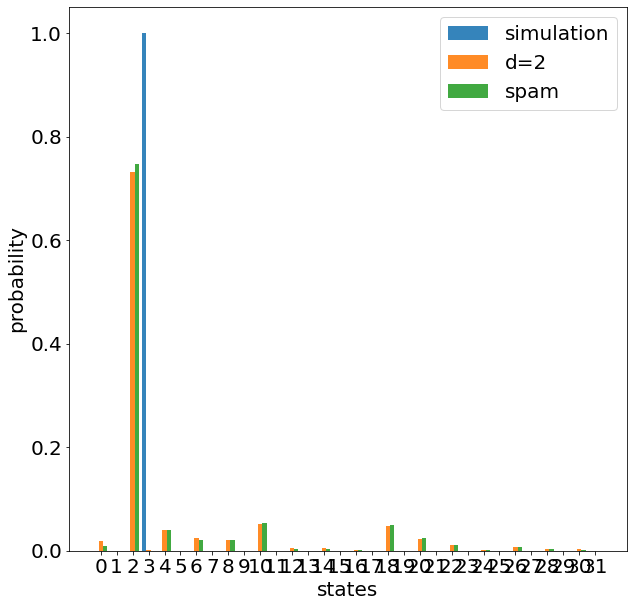

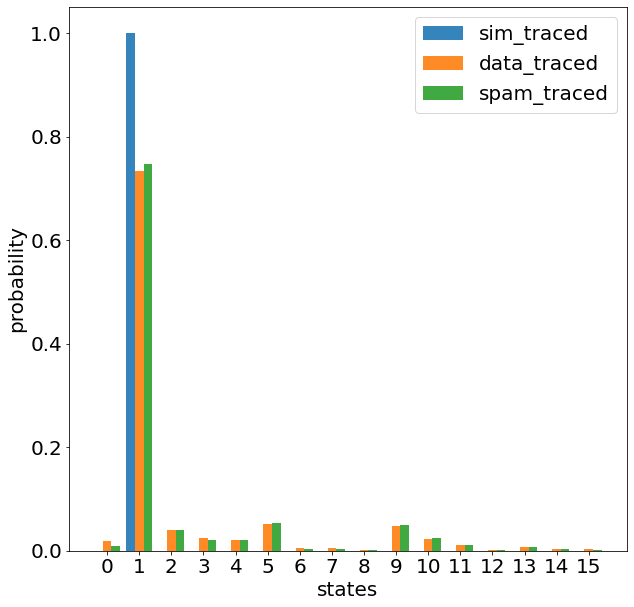

2023-04-26-151500_Line_002.txt
counts: [257, 9, 34, 79, 24, 13, 6, 25, 2977, 49, 61, 105, 246, 78, 4, 33]
counts_ibm_mapping_dic: {'0000': 257, '1000': 9, '0100': 34, '1100': 79, '0010': 24, '1010': 13, '0110': 6, '1110': 25, '0001': 2977, '1001': 49, '0101': 61, '1101': 105, '0011': 246, '1011': 78, '0111': 4, '1111': 33}
HAD2:HAD3:CNOT25:CNOT34:SKAX2+1.0000:SKAX1+1.0000:XA230.2500+:AZ2+1.0000:SKAX5+1.0000:SKAX4+1.0000:SKAY3+1.0000:XA230.2500+:SKAX1+1.0000:AZ3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



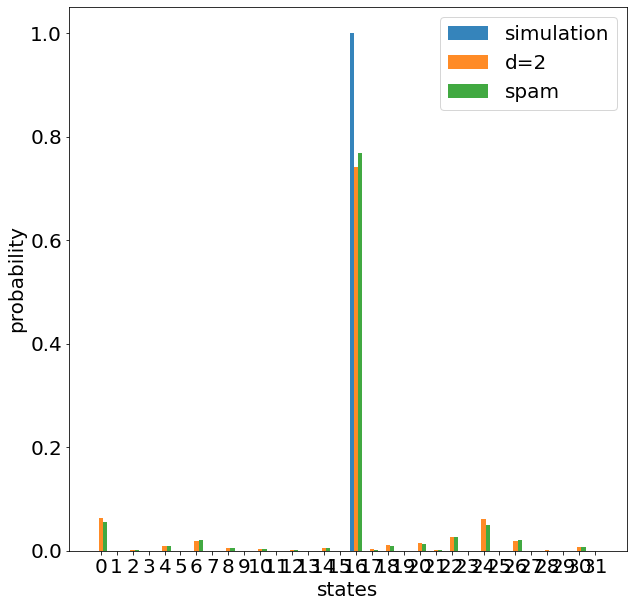

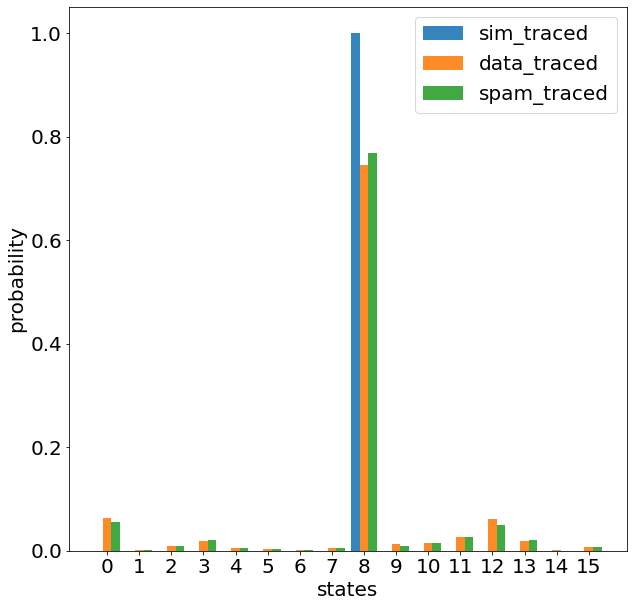

2023-04-26-151540_Line_003.txt
counts: [16, 60, 35, 10, 20, 512, 73, 51, 45, 142, 30, 14, 53, 2721, 91, 127]
counts_ibm_mapping_dic: {'0000': 16, '1000': 60, '0100': 35, '1100': 10, '0010': 20, '1010': 512, '0110': 73, '1110': 51, '0001': 45, '1001': 142, '0101': 30, '1101': 14, '0011': 53, '1011': 2721, '0111': 91, '1111': 127}
HAD2:HAD3:CNOT25:CNOT34:AZ2+1.0000:SKAX1+1.0000:XA230.2500+:SKAX1+1.0000:SKAX5+1.0000:SKAX4+1.0000:SKAX3+1.0000:XA230.2500+:SKAX2+1.0000:SKAY3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



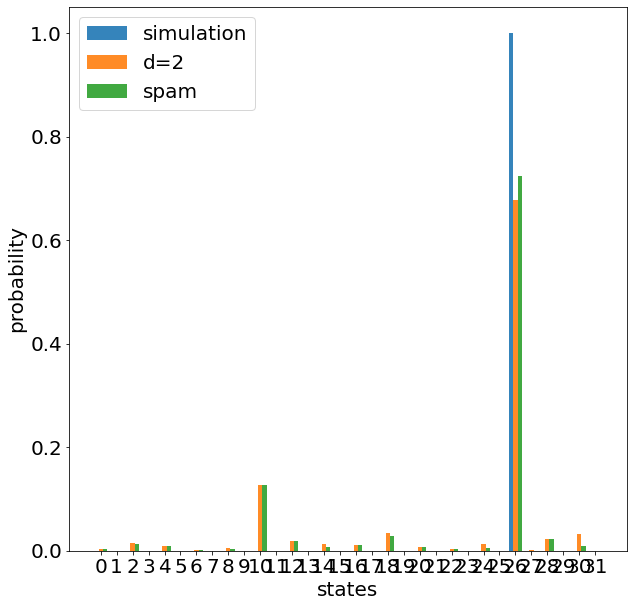

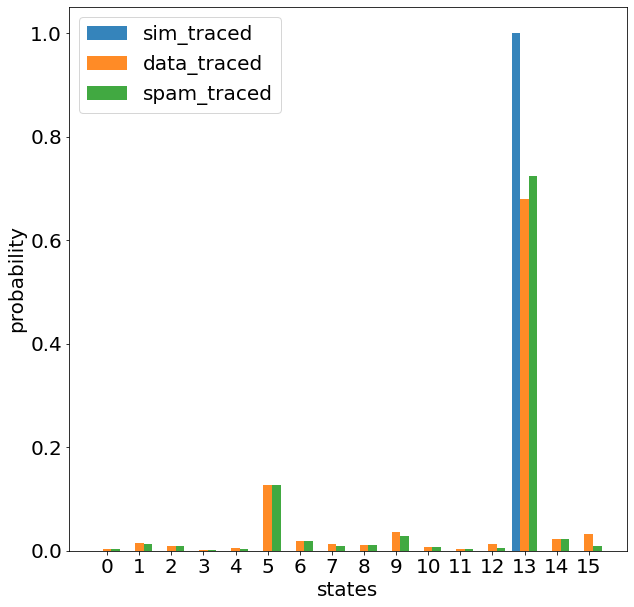

2023-04-26-151730_Line_004.txt
counts: [55, 15, 3, 26, 339, 21, 28, 55, 185, 48, 8, 53, 2958, 101, 53, 52]
counts_ibm_mapping_dic: {'0000': 55, '1000': 15, '0100': 3, '1100': 26, '0010': 339, '1010': 21, '0110': 28, '1110': 55, '0001': 185, '1001': 48, '0101': 8, '1101': 53, '0011': 2958, '1011': 101, '0111': 53, '1111': 52}
HAD2:HAD3:CNOT25:CNOT34:AZ2+1.0000:SKAX1+1.0000:XA230.2500+:SKAY2+1.0000:SKAX5+1.0000:SKAX4+1.0000:AZ3+1.0000:XA230.2500+:AZ2+1.0000:SKAX3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



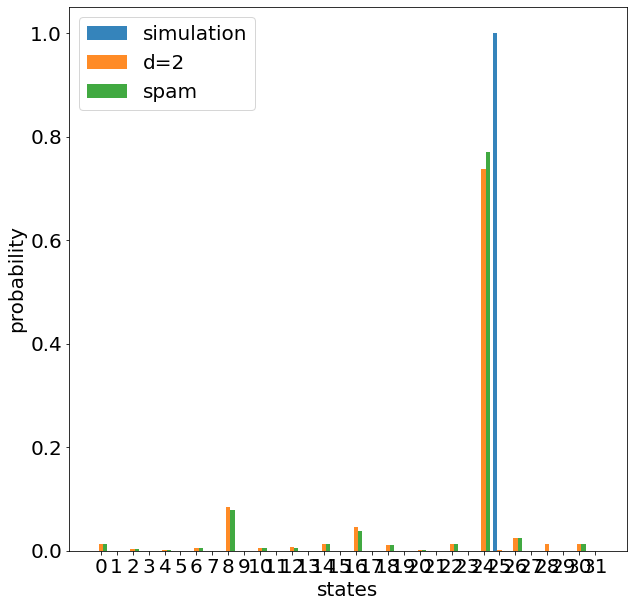

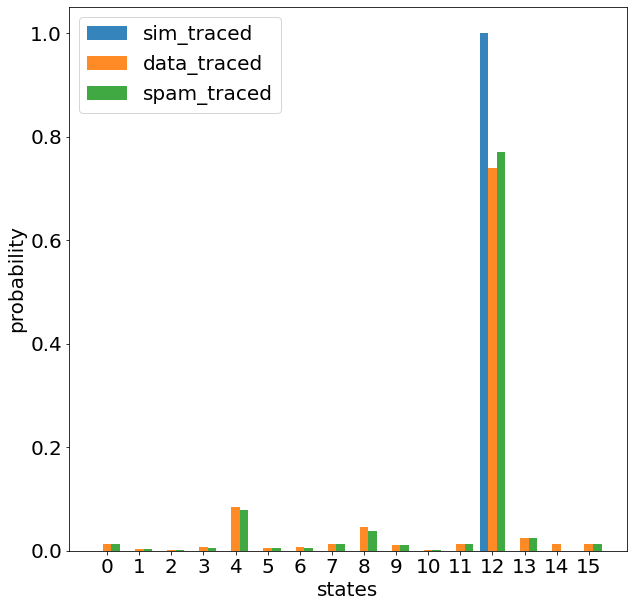

2023-04-26-151809_Line_005.txt
counts: [10, 6, 20, 75, 19, 36, 17, 553, 52, 13, 52, 165, 15, 83, 72, 2812]
counts_ibm_mapping_dic: {'0000': 10, '1000': 6, '0100': 20, '1100': 75, '0010': 19, '1010': 36, '0110': 17, '1110': 553, '0001': 52, '1001': 13, '0101': 52, '1101': 165, '0011': 15, '1011': 83, '0111': 72, '1111': 2812}
HAD2:HAD3:CNOT25:CNOT34:SKAY2+1.0000:AZ3+1.0000:XA230.2500+:SKAX2+1.0000:SKAX5+1.0000:SKAX4+1.0000:AZ3+1.0000:XA230.2500+:SKAX2+1.0000:SKAY3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



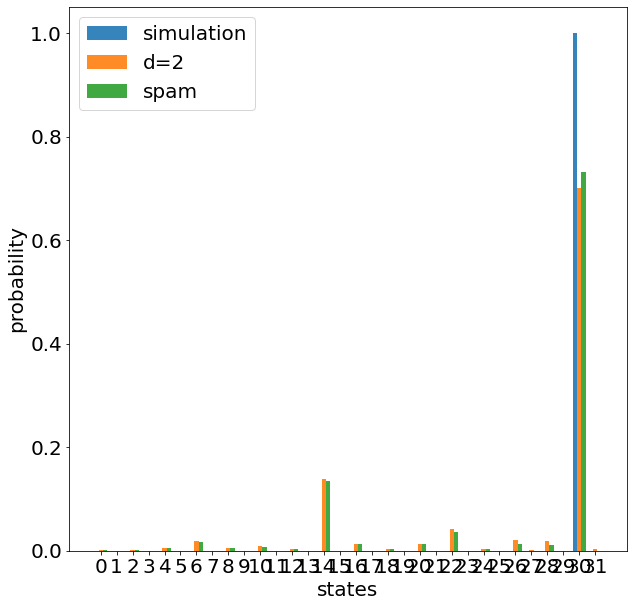

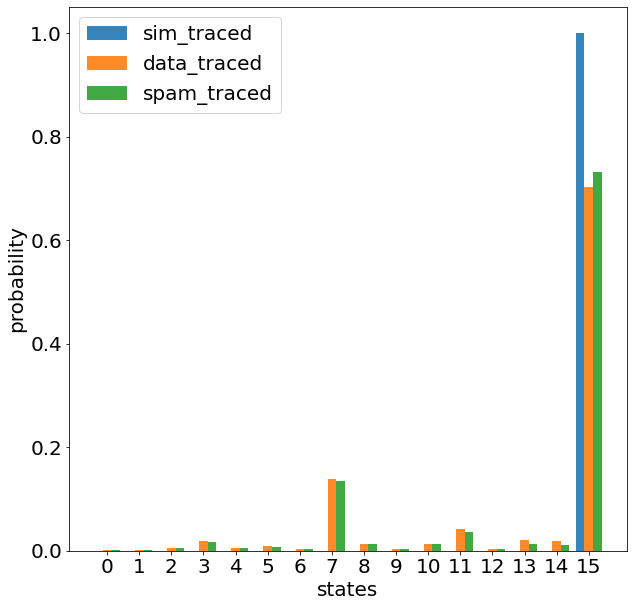

2023-04-26-151849_Line_006.txt
counts: [84, 2897, 148, 85, 49, 190, 40, 31, 19, 219, 113, 50, 9, 26, 26, 14]
counts_ibm_mapping_dic: {'0000': 84, '1000': 2897, '0100': 148, '1100': 85, '0010': 49, '1010': 190, '0110': 40, '1110': 31, '0001': 19, '1001': 219, '0101': 113, '1101': 50, '0011': 9, '1011': 26, '0111': 26, '1111': 14}
HAD2:HAD3:CNOT25:CNOT34:SKAX2+1.0000:SKAX1+1.0000:XA230.2500+:SKAX1+1.0000:SKAX5+1.0000:SKAX4+1.0000:SKAX3+1.0000:XA230.2500+:SKAX1+1.0000:SKAX3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



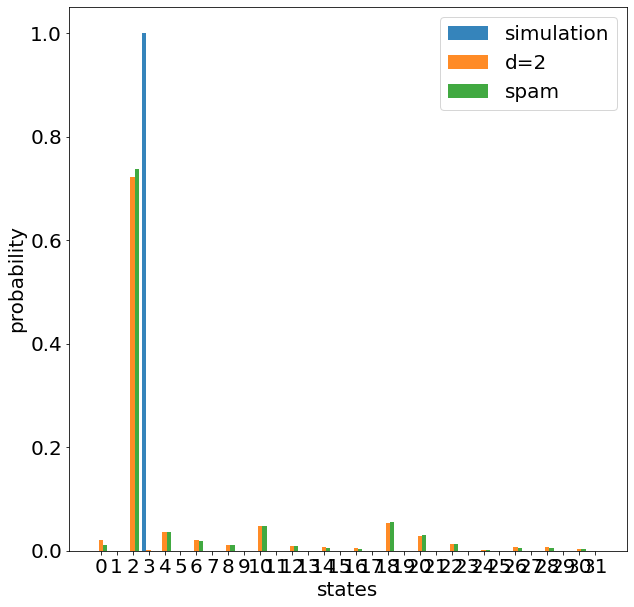

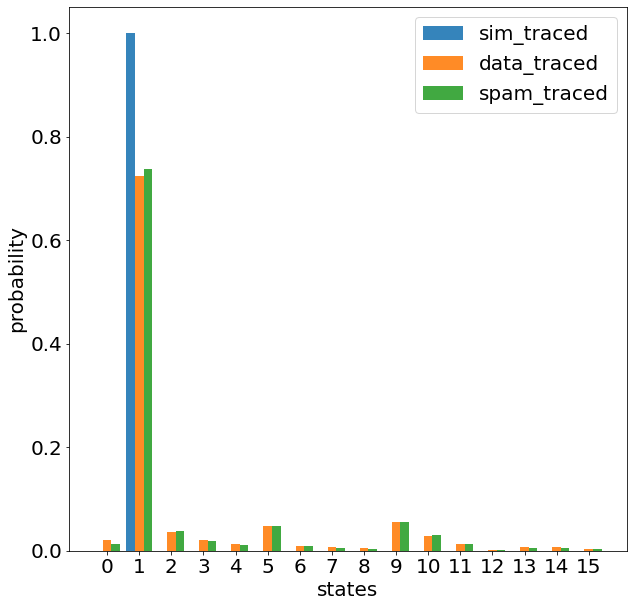

2023-04-26-153218_Line_007.txt
counts: [4, 2, 18, 32, 35, 45, 14, 562, 17, 4, 55, 115, 16, 91, 60, 2930]
counts_ibm_mapping_dic: {'0000': 4, '1000': 2, '0100': 18, '1100': 32, '0010': 35, '1010': 45, '0110': 14, '1110': 562, '0001': 17, '1001': 4, '0101': 55, '1101': 115, '0011': 16, '1011': 91, '0111': 60, '1111': 2930}
HAD2:HAD3:CNOT25:CNOT34:SKAX2+1.0000:SKAX3+1.0000:XA230.2500+:SKAY2+1.0000:SKAX5+1.0000:SKAX4+1.0000:SKAX3+1.0000:XA230.2500+:SKAX2+1.0000:SKAY3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



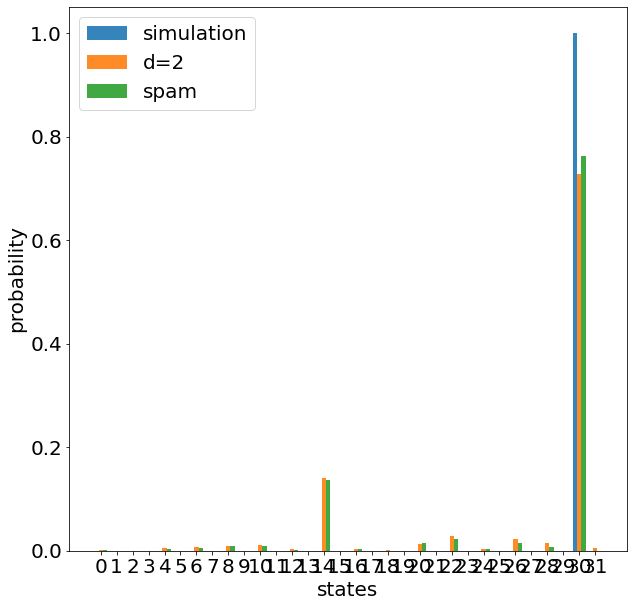

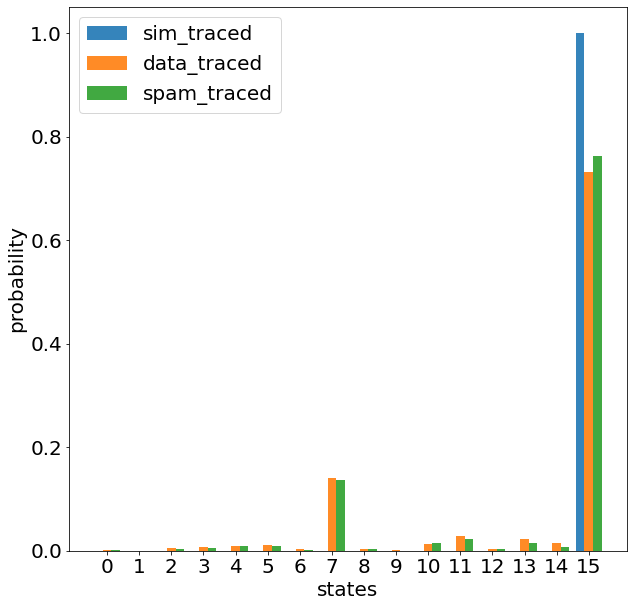

2023-04-26-153257_Line_008.txt
counts: [40, 7, 48, 151, 183, 78, 77, 2537, 9, 6, 19, 76, 47, 45, 35, 642]
counts_ibm_mapping_dic: {'0000': 40, '1000': 7, '0100': 48, '1100': 151, '0010': 183, '1010': 78, '0110': 77, '1110': 2537, '0001': 9, '1001': 6, '0101': 19, '1101': 76, '0011': 47, '1011': 45, '0111': 35, '1111': 642}
HAD2:HAD3:CNOT25:CNOT34:AZ2+1.0000:SKAY3+1.0000:XA230.2500+:SKAY2+1.0000:SKAX5+1.0000:SKAX4+1.0000:SKAY3+1.0000:XA230.2500+:SKAX2+1.0000:AZ3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



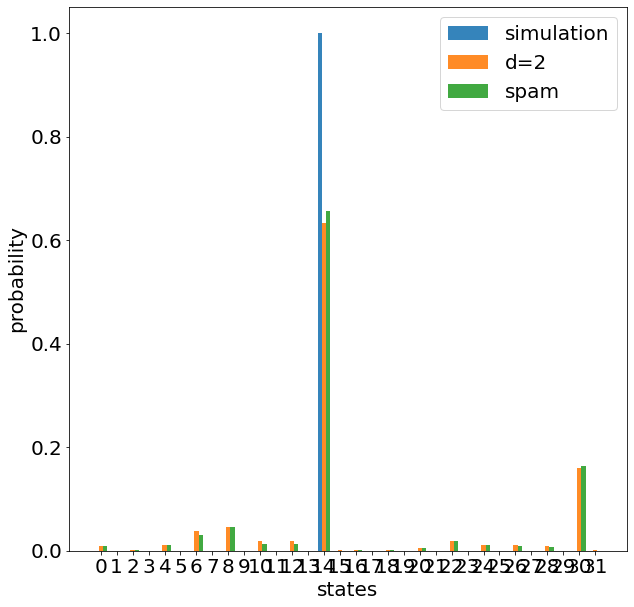

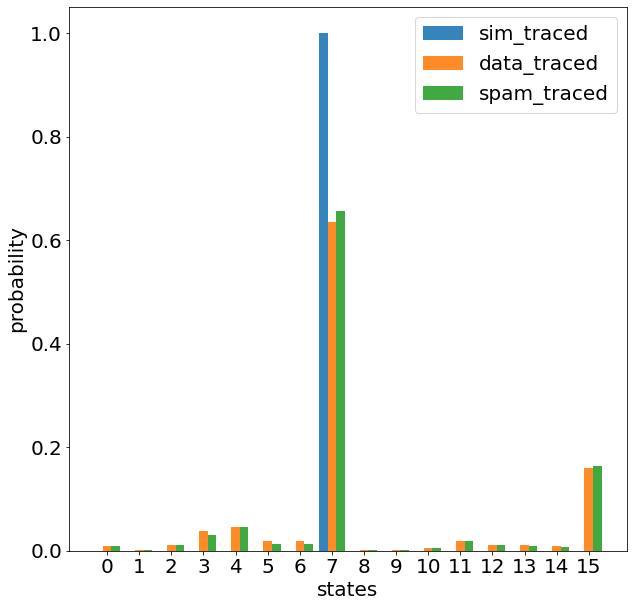

2023-04-26-153336_Line_009.txt
counts: [387, 6, 33, 57, 88, 8, 7, 12, 2856, 42, 48, 45, 330, 60, 9, 12]
counts_ibm_mapping_dic: {'0000': 387, '1000': 6, '0100': 33, '1100': 57, '0010': 88, '1010': 8, '0110': 7, '1110': 12, '0001': 2856, '1001': 42, '0101': 48, '1101': 45, '0011': 330, '1011': 60, '0111': 9, '1111': 12}
HAD2:HAD3:CNOT25:CNOT34:AZ2+1.0000:SKAX1+1.0000:XA230.2500+:SKAX1+1.0000:SKAX5+1.0000:SKAX4+1.0000:SKAY3+1.0000:XA230.2500+:SKAX1+1.0000:SKAY3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



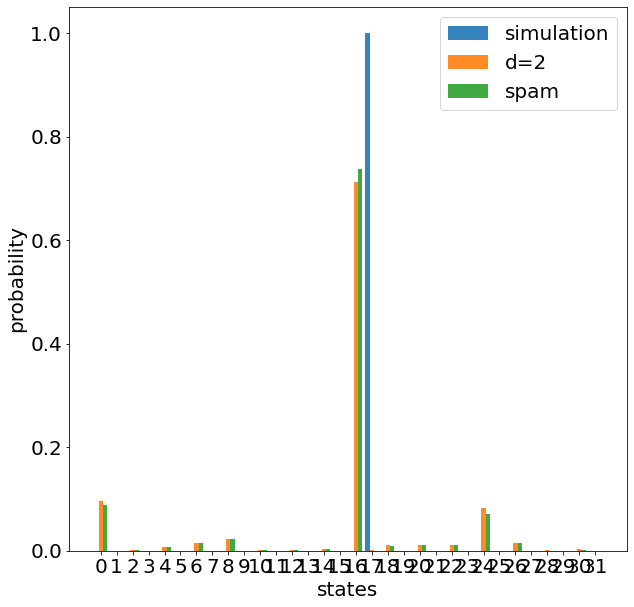

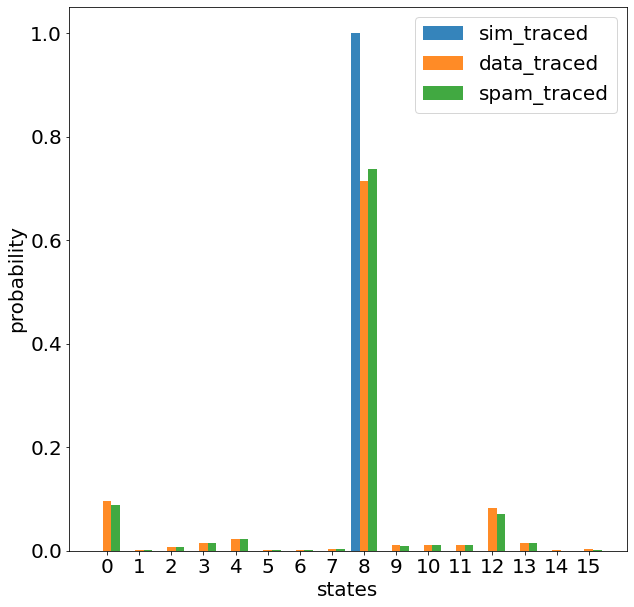

2023-04-26-153415_Line_010.txt
counts: [79, 14, 2615, 41, 15, 18, 252, 40, 33, 58, 619, 20, 7, 11, 152, 26]
counts_ibm_mapping_dic: {'0000': 79, '1000': 14, '0100': 2615, '1100': 41, '0010': 15, '1010': 18, '0110': 252, '1110': 40, '0001': 33, '1001': 58, '0101': 619, '1101': 20, '0011': 7, '1011': 11, '0111': 152, '1111': 26}
HAD2:HAD3:CNOT25:CNOT34:SKAX2+1.0000:SKAX1+1.0000:XA230.2500+:SKAX1+1.0000:SKAX5+1.0000:SKAX4+1.0000:SKAY3+1.0000:XA230.2500+:SKAX1+1.0000:SKAY3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2


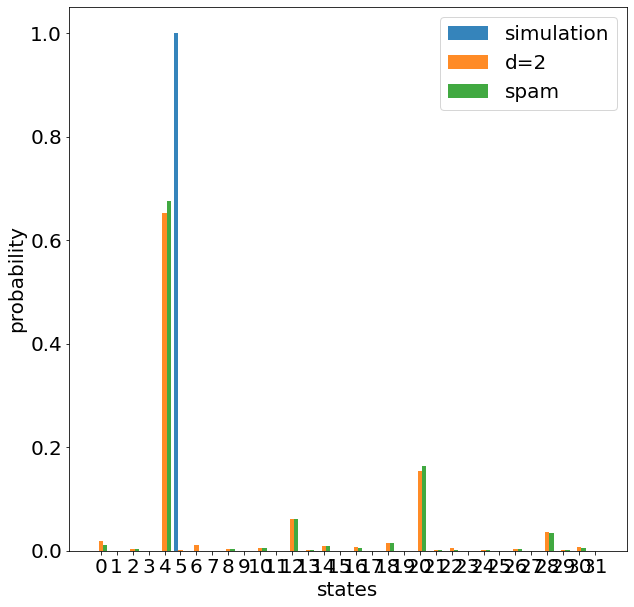

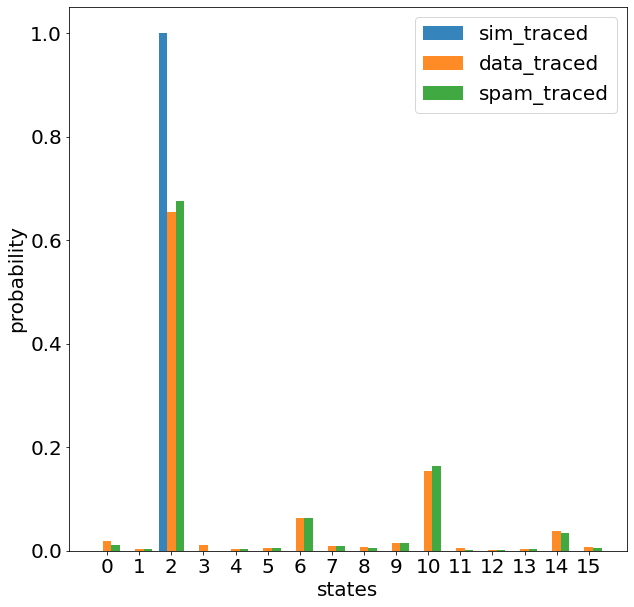

In [8]:
filenames_data=[]
counts_d2=[]
counts_d2_spam=[]
shots=4000
counts=[]
counts_spam=[]
filenames_data=filenames_d2.copy()
# print (filenames_data)
# print (len(filenames_data))
paf_data=paf_data_d2
circuit=c_d2
for i in range (len(filenames_data)):
    print (filenames_data[i])
    a.Import(paf_data+filenames_data[i],keep_file=True)
    data_traced=Trace_Out(a,[0,1,2,3])
    counts=[round(shots*x) for x in  data_traced.population]
    print ("counts:", counts)
    counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping(counts,nqubit)
    print ("counts_ibm_mapping_dic:",counts_ibm_mapping_dic)
    counts_d2.append(counts_ibm_mapping_dic)
    
    a_s=spam1.Correct_SPAM(a)
    data_traced_spam=Trace_Out(a_s,[0,1,2,3])
    counts_spam=[round(shots*x) for x in  data_traced_spam.population]
    counts_ibm_mapping_spam, counts_ibm_mapping_dic_spam=map_statepop_2_ibm_mapping(counts_spam,nqubit)
    counts_d2_spam.append(counts_ibm_mapping_dic_spam)

    b_c.Interpret_GatesLab_Sequence(circuit[i])
    print (circuit[i])
    b=b_c.Simulate()
    sim_traced=Trace_Out(b,[0,1,2,3])
    Display_States_Population(states=[b,a,a_s],label=["simulation","d=2","spam"])
    Display_States_Population(states=[sim_traced,data_traced,data_traced_spam],label=["sim_traced","data_traced","spam_traced"])
# #         

['2023-04-26-153753_Line_001.txt', '2023-04-26-153839_Line_002.txt', '2023-04-26-154038_Line_003.txt', '2023-04-26-154123_Line_004.txt', '2023-04-26-154319_Line_005.txt', '2023-04-26-154405_Line_006.txt', '2023-04-26-154602_Line_007.txt', '2023-04-26-154646_Line_008.txt', '2023-04-26-162116_Line_009.txt', '2023-04-26-162203_Line_010.txt']
2023-04-26-153753_Line_001.txt
HAD2:HAD3:CNOT25:CNOT34:SKAX1+1.0000:AZ3+1.0000:XA230.2500+:SKAY2+1.0000:SKAX1+1.0000:XA230.2500+:SKAX2+1.0000:SKAX5+1.0000:SKAX4+1.0000:AZ3+1.0000:XA230.2500+:SKAY2+1.0000:SKAY3+1.0000:XA230.2500+:SKAX1+1.0000:AZ3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



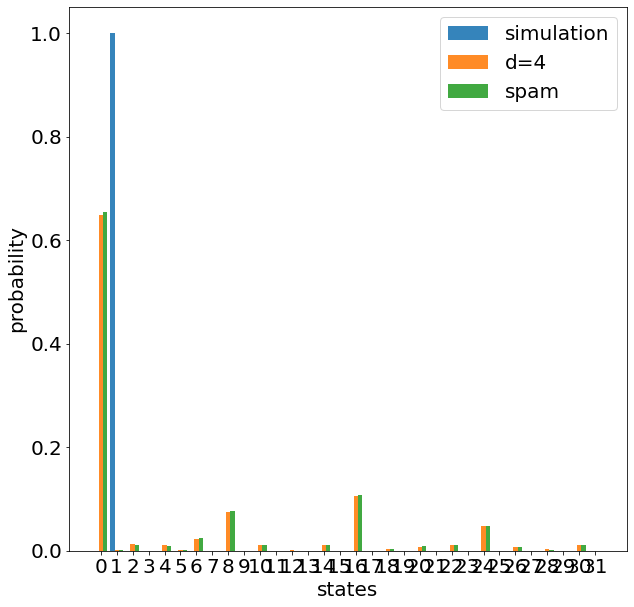

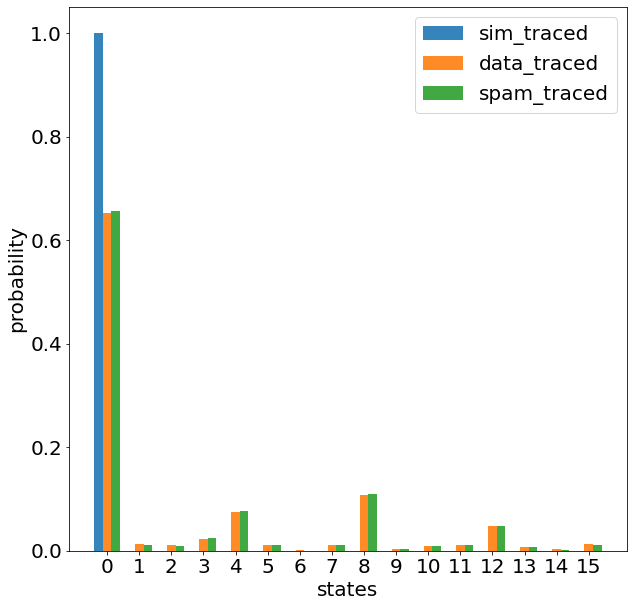

2023-04-26-153839_Line_002.txt
HAD2:HAD3:CNOT25:CNOT34:AZ2+1.0000:SKAY3+1.0000:XA230.2500+:AZ2+1.0000:SKAY3+1.0000:XA230.2500+:SKAX1+1.0000:SKAX5+1.0000:SKAX4+1.0000:AZ3+1.0000:XA230.2500+:SKAY2+1.0000:SKAY3+1.0000:XA230.2500+:SKAX2+1.0000:SKAX1+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



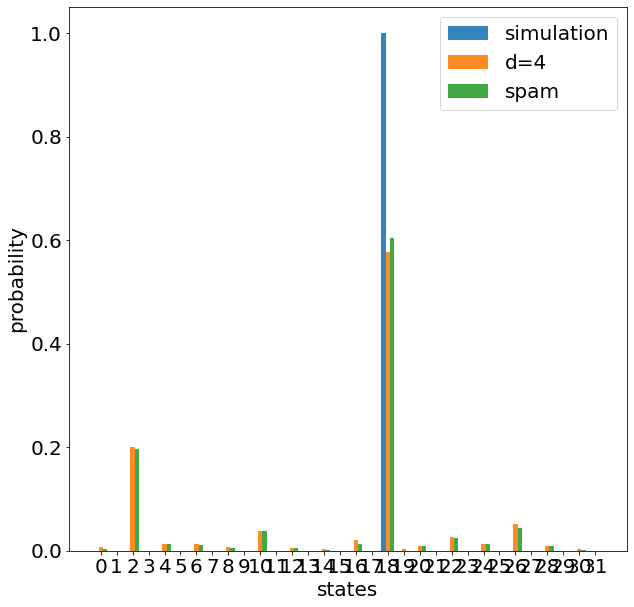

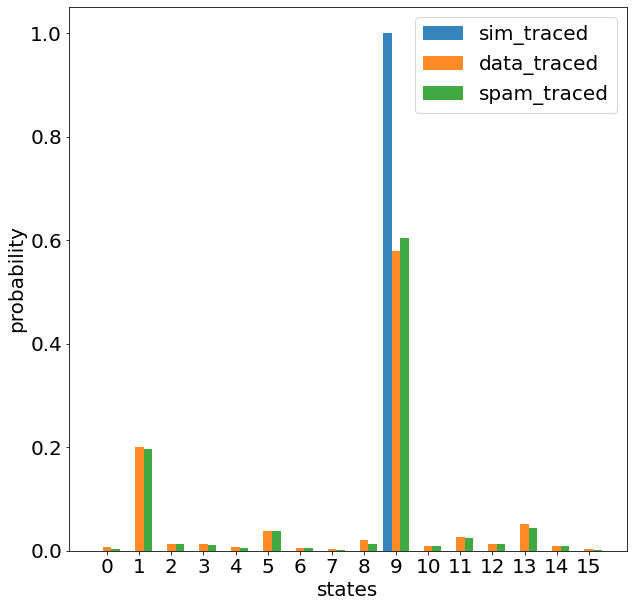

2023-04-26-154038_Line_003.txt
HAD2:HAD3:CNOT25:CNOT34:SKAY2+1.0000:SKAY3+1.0000:XA230.2500+:SKAX1+1.0000:SKAX3+1.0000:XA230.2500+:SKAX2+1.0000:SKAX5+1.0000:SKAX4+1.0000:SKAX1+1.0000:XA230.2500+:SKAX1+1.0000:SKAY3+1.0000:XA230.2500+:SKAX1+1.0000:AZ3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



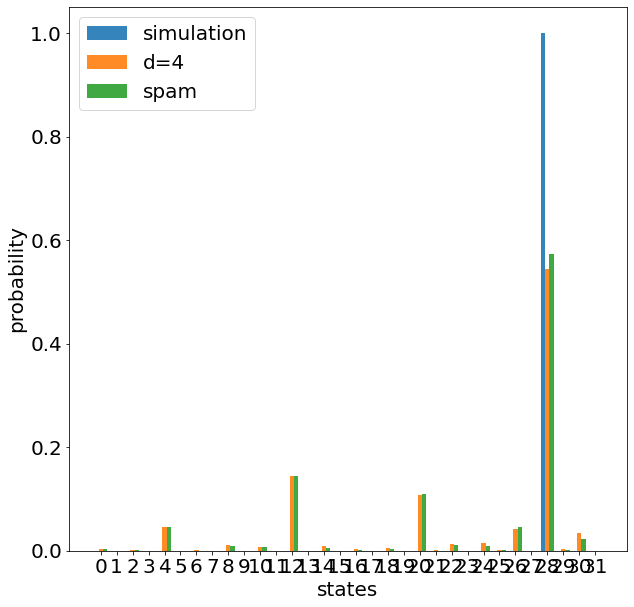

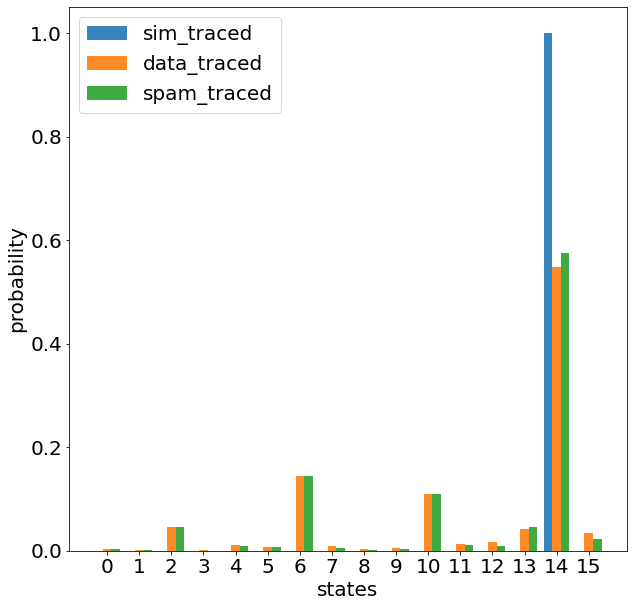

2023-04-26-154123_Line_004.txt
HAD2:HAD3:CNOT25:CNOT34:SKAX1+1.0000:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:SKAX1+1.0000:SKAX5+1.0000:SKAX4+1.0000:SKAX1+1.0000:XA230.2500+:SKAY2+1.0000:SKAY3+1.0000:XA230.2500+:SKAX1+1.0000:SKAY3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



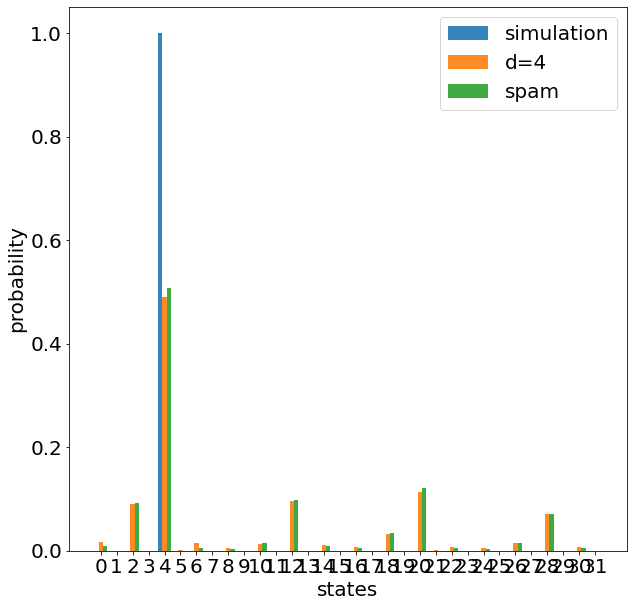

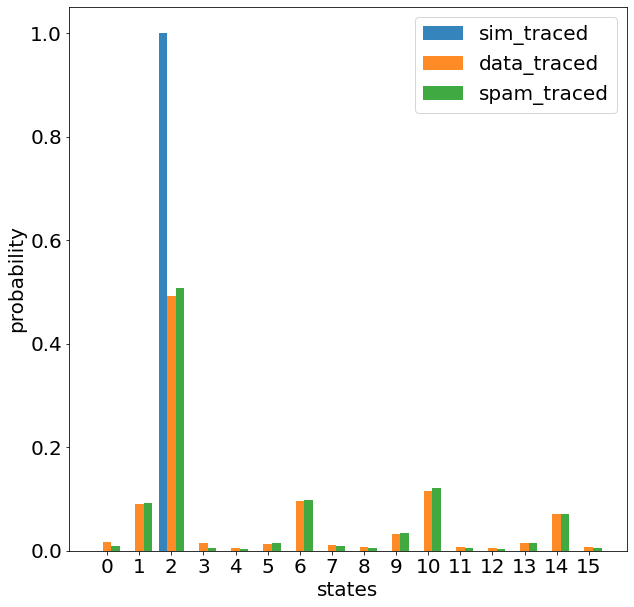

2023-04-26-154319_Line_005.txt
HAD2:HAD3:CNOT25:CNOT34:SKAY2+1.0000:SKAX1+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:SKAY2+1.0000:SKAX5+1.0000:SKAX4+1.0000:AZ3+1.0000:XA230.2500+:SKAX1+1.0000:AZ3+1.0000:XA230.2500+:SKAX2+1.0000:AZ3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



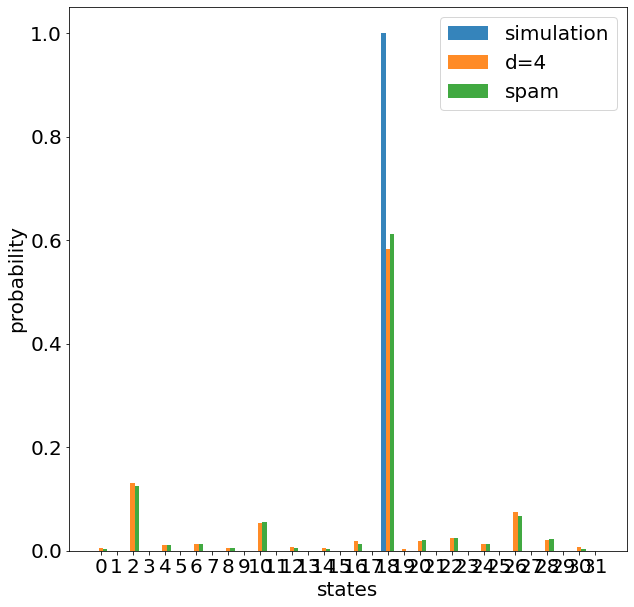

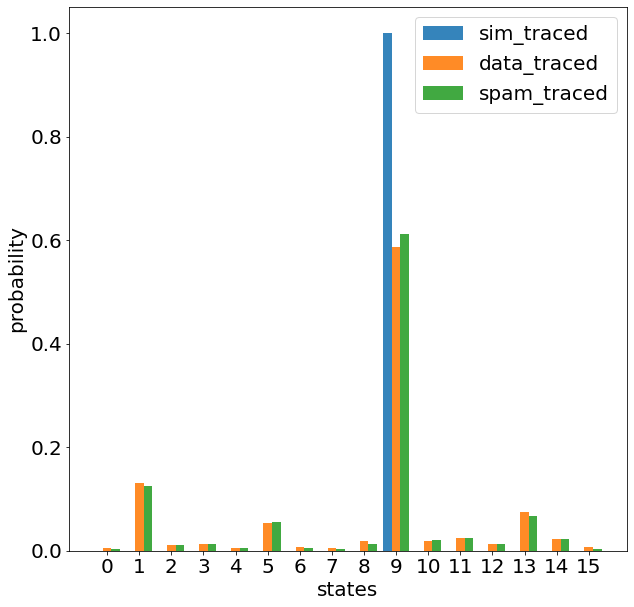

2023-04-26-154405_Line_006.txt
HAD2:HAD3:CNOT25:CNOT34:SKAY2+1.0000:SKAX1+1.0000:XA230.2500+:SKAX2+1.0000:SKAX3+1.0000:XA230.2500+:AZ2+1.0000:SKAX5+1.0000:SKAX4+1.0000:SKAY3+1.0000:XA230.2500+:SKAX1+1.0000:AZ3+1.0000:XA230.2500+:SKAY2+1.0000:AZ3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



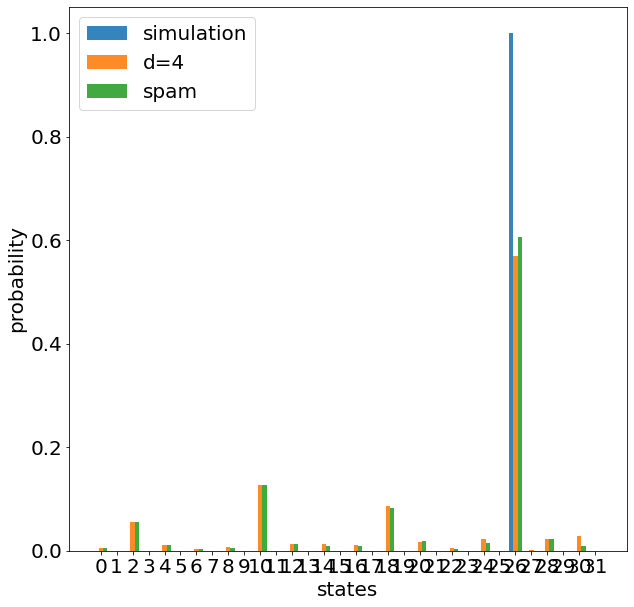

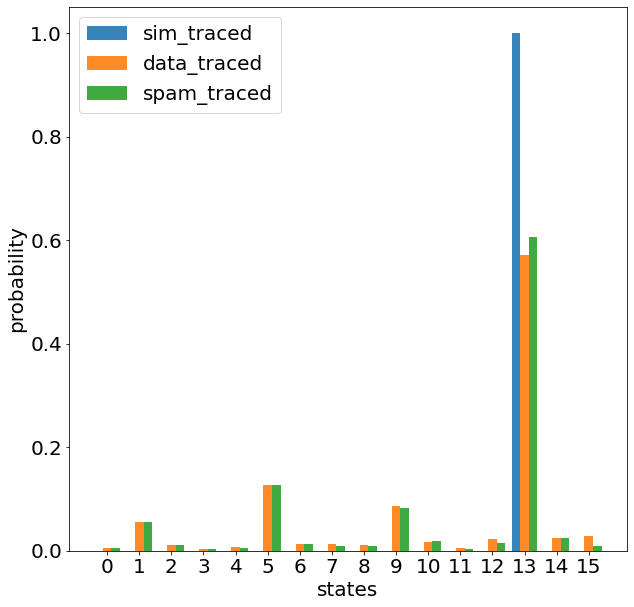

2023-04-26-154602_Line_007.txt
HAD2:HAD3:CNOT25:CNOT34:AZ2+1.0000:SKAY3+1.0000:XA230.2500+:SKAX2+1.0000:SKAX3+1.0000:XA230.2500+:AZ2+1.0000:SKAX5+1.0000:SKAX4+1.0000:AZ3+1.0000:XA230.2500+:AZ2+1.0000:SKAY3+1.0000:XA230.2500+:SKAY2+1.0000:SKAX1+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



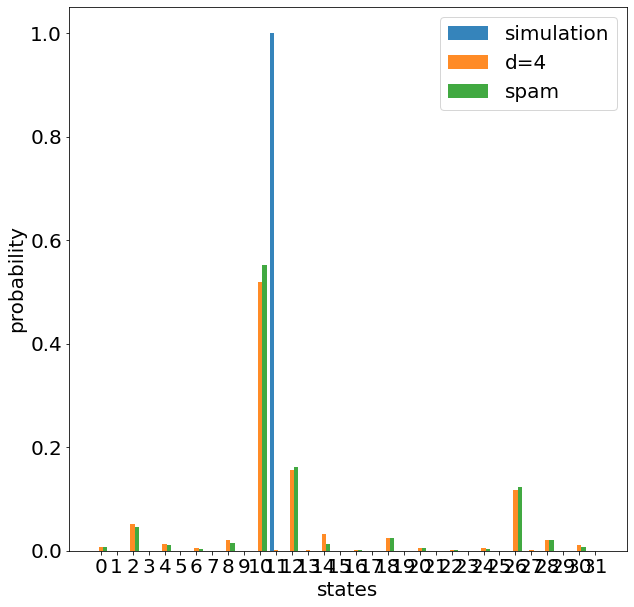

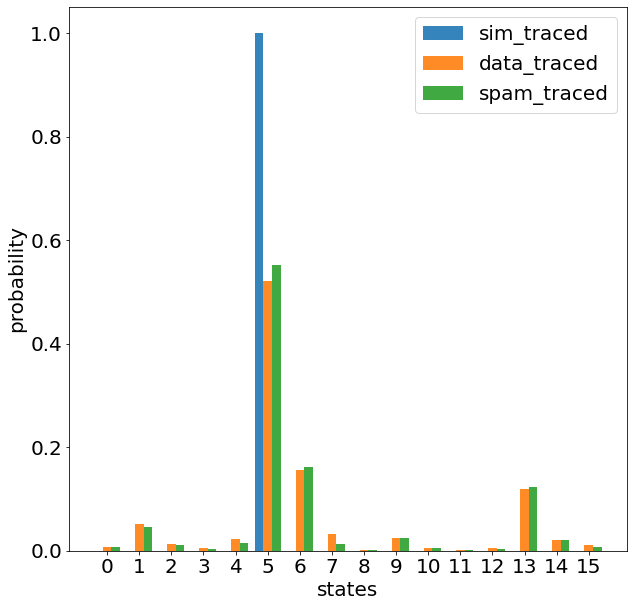

2023-04-26-154646_Line_008.txt
HAD2:HAD3:CNOT25:CNOT34:AZ2+1.0000:SKAX3+1.0000:XA230.2500+:AZ2+1.0000:SKAX3+1.0000:XA230.2500+:AZ2+1.0000:SKAX5+1.0000:SKAX4+1.0000:AZ3+1.0000:XA230.2500+:SKAX1+1.0000:SKAY3+1.0000:XA230.2500+:SKAY2+1.0000:SKAX3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



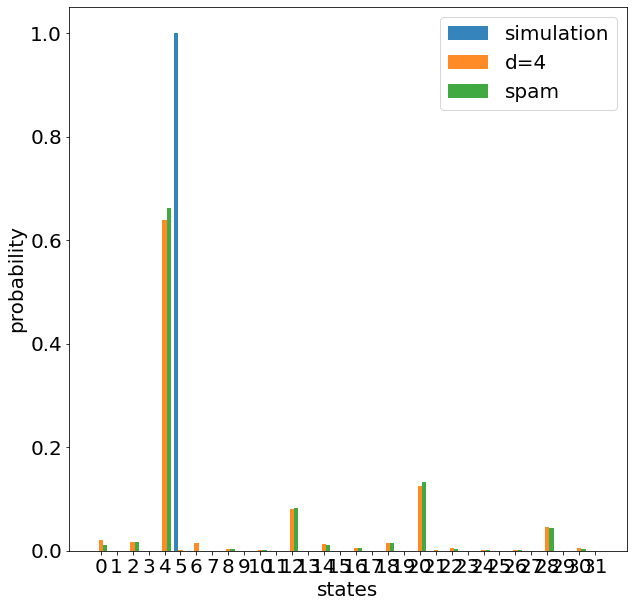

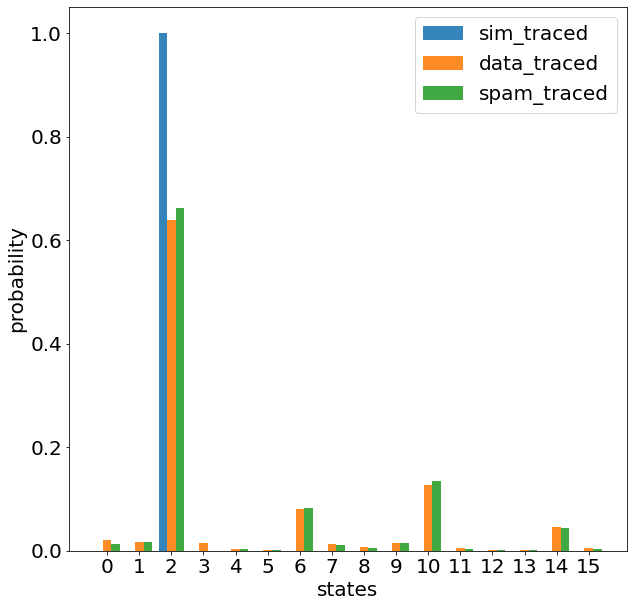

2023-04-26-162116_Line_009.txt
HAD2:HAD3:CNOT25:CNOT34:SKAY2+1.0000:SKAX1+1.0000:XA230.2500+:SKAX2+1.0000:AZ3+1.0000:XA230.2500+:SKAX1+1.0000:SKAX5+1.0000:SKAX4+1.0000:SKAY3+1.0000:XA230.2500+:SKAY2+1.0000:SKAX1+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



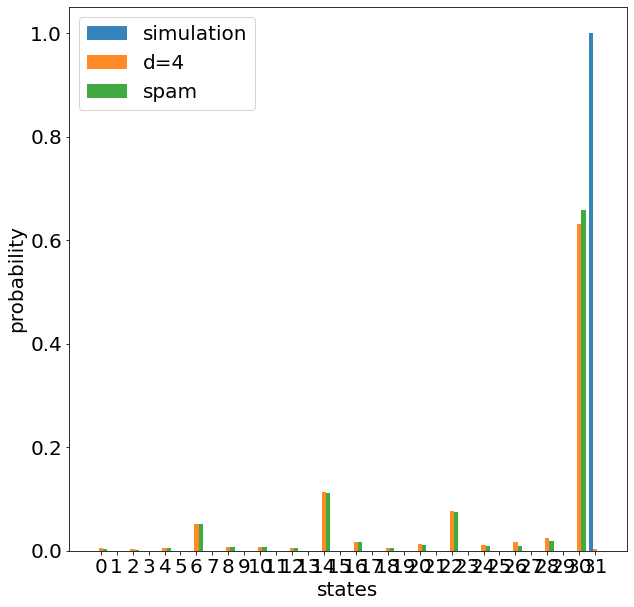

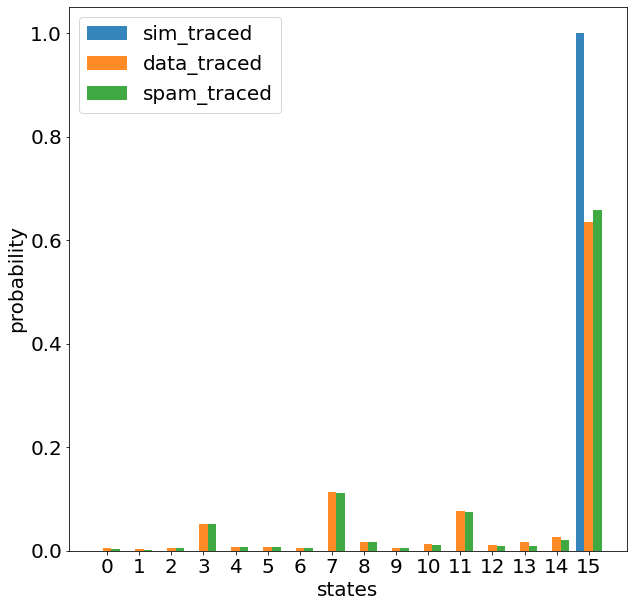

2023-04-26-162203_Line_010.txt
HAD2:HAD3:CNOT25:CNOT34:SKAX1+1.0000:SKAX3+1.0000:XA230.2500+:AZ2+1.0000:SKAX1+1.0000:XA230.2500+:AZ2+1.0000:SKAX5+1.0000:SKAX4+1.0000:SKAY3+1.0000:XA230.2500+:SKAX2+1.0000:SKAX3+1.0000:XA230.2500+:SKAX2+1.0000:SKAY3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2


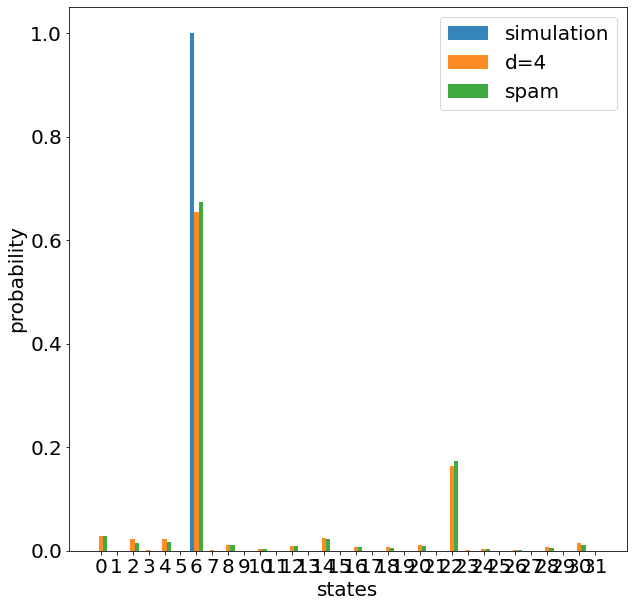

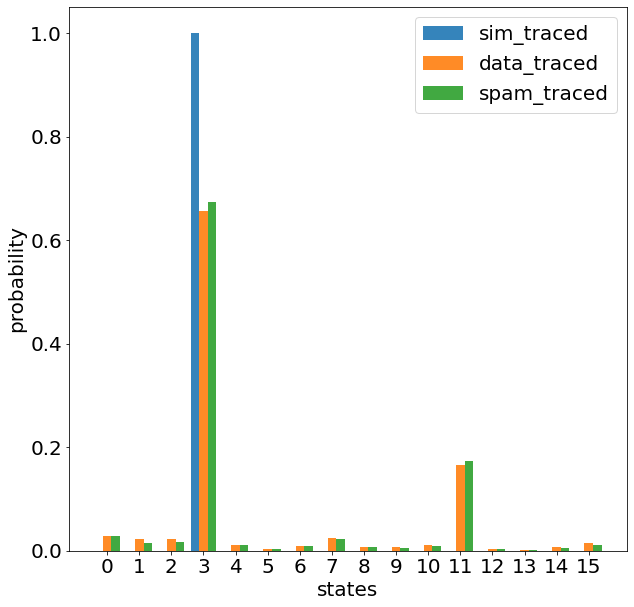

In [9]:
filenames_data=[]
counts_d4=[]
counts_d4_spam=[]
counts=[]
counts_spam=[]
filenames_data=filenames_d4.copy()
print (filenames_data)
# print (len(filenames_data))
paf_data=paf_data_d4
circuit=c_d4
for i in range (len(filenames_data)):
    print (filenames_data[i])
    a.Import(paf_data+filenames_data[i],keep_file=True)
    data_traced=Trace_Out(a,[0,1,2,3])
    counts=[round(shots*x) for x in  data_traced.population]
    counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping(counts,nqubit)
    counts_d4.append(counts_ibm_mapping_dic)
    
    
    a_s=spam2.Correct_SPAM(a)
    data_traced_spam=Trace_Out(a_s,[0,1,2,3])
    counts_spam=[round(shots*x) for x in  data_traced_spam.population]
    counts_ibm_mapping_spam, counts_ibm_mapping_dic_spam=map_statepop_2_ibm_mapping(counts_spam,nqubit)
    counts_d4_spam.append(counts_ibm_mapping_dic_spam)

    b_c.Interpret_GatesLab_Sequence(circuit[i])
    print (circuit[i])
    b=b_c.Simulate()
    sim_traced=Trace_Out(b,[0,1,2,3])
    Display_States_Population(states=[b,a,a_s],label=["simulation","d=4","spam"])
    Display_States_Population(states=[sim_traced,data_traced,data_traced_spam],label=["sim_traced","data_traced","spam_traced"])
# #         

2023-04-26-164507_Line_001.txt
HAD2:HAD3:CNOT25:CNOT34:SKAY2+1.0000:SKAX3+1.0000:XA230.2500+:SKAX1+1.0000:SKAX3+1.0000:XA230.2500+:AZ2+1.0000:SKAX1+1.0000:XA230.2500+:SKAX1+1.0000:SKAX3+1.0000:XA230.2500+:SKAX1+1.0000:SKAX5+1.0000:SKAX4+1.0000:SKAY3+1.0000:XA230.2500+:SKAX1+1.0000:SKAX1+1.0000:XA230.2500+:AZ2+1.0000:SKAX1+1.0000:XA230.2500+:SKAX1+1.0000:SKAX1+1.0000:XA230.2500+:SKAX2+1.0000:SKAY3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



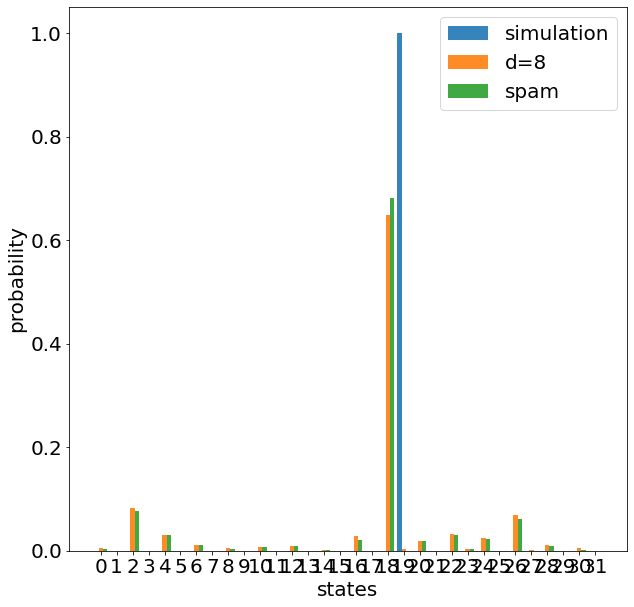

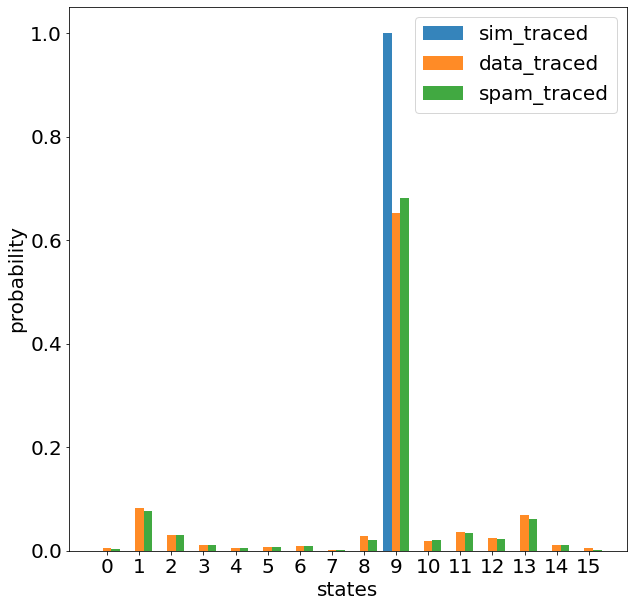

2023-04-26-164609_Line_002.txt
HAD2:HAD3:CNOT25:CNOT34:SKAY2+1.0000:SKAY3+1.0000:XA230.2500+:SKAY2+1.0000:SKAX3+1.0000:XA230.2500+:SKAY2+1.0000:SKAX3+1.0000:XA230.2500+:SKAY2+1.0000:SKAX3+1.0000:XA230.2500+:SKAX1+1.0000:SKAX5+1.0000:SKAX4+1.0000:SKAY3+1.0000:XA230.2500+:SKAY2+1.0000:SKAX1+1.0000:XA230.2500+:SKAY2+1.0000:AZ3+1.0000:XA230.2500+:SKAX2+1.0000:AZ3+1.0000:XA230.2500+:SKAY2+1.0000:SKAX3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



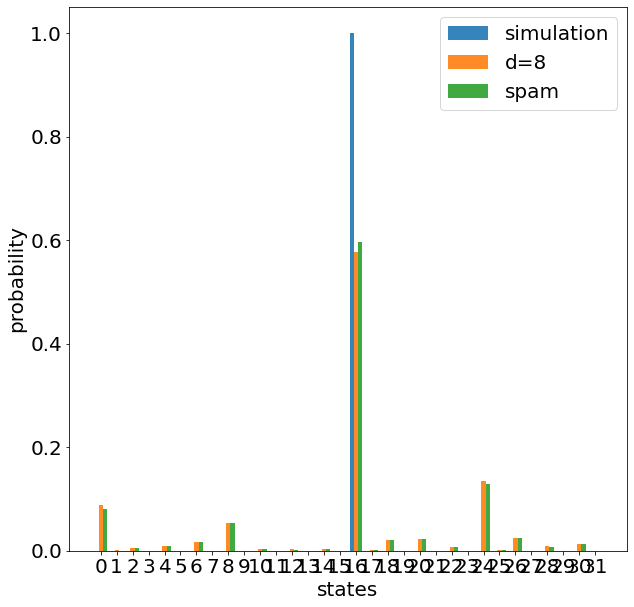

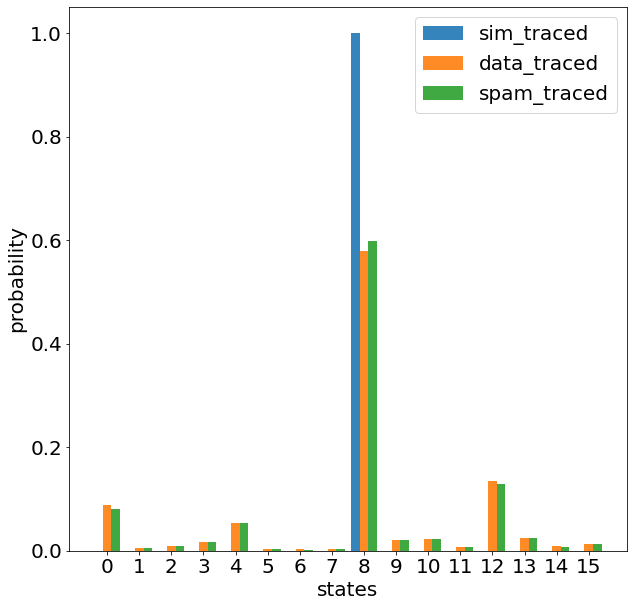

2023-04-26-164825_Line_003.txt
HAD2:HAD3:CNOT25:CNOT34:SKAX2+1.0000:AZ3+1.0000:XA230.2500+:SKAX1+1.0000:SKAX3+1.0000:XA230.2500+:AZ2+1.0000:SKAX3+1.0000:XA230.2500+:SKAY2+1.0000:SKAX3+1.0000:XA230.2500+:SKAX2+1.0000:SKAX5+1.0000:SKAX4+1.0000:SKAX1+1.0000:XA230.2500+:SKAX1+1.0000:AZ3+1.0000:XA230.2500+:SKAX2+1.0000:SKAY3+1.0000:XA230.2500+:SKAX2+1.0000:SKAX1+1.0000:XA230.2500+:SKAX1+1.0000:SKAX1+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



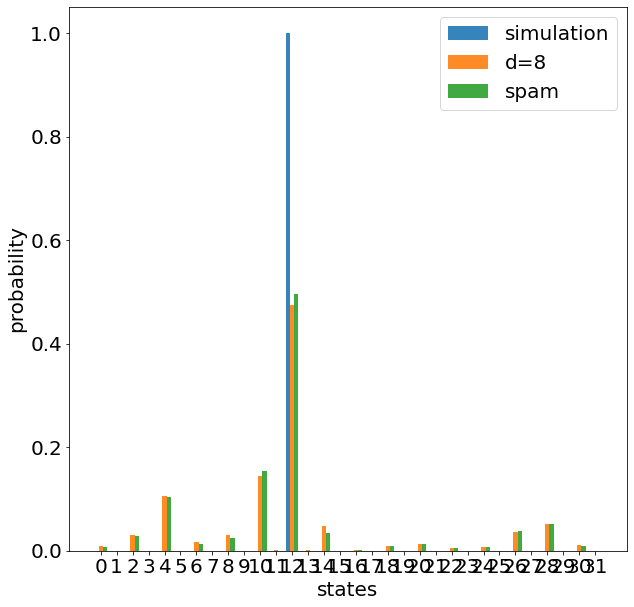

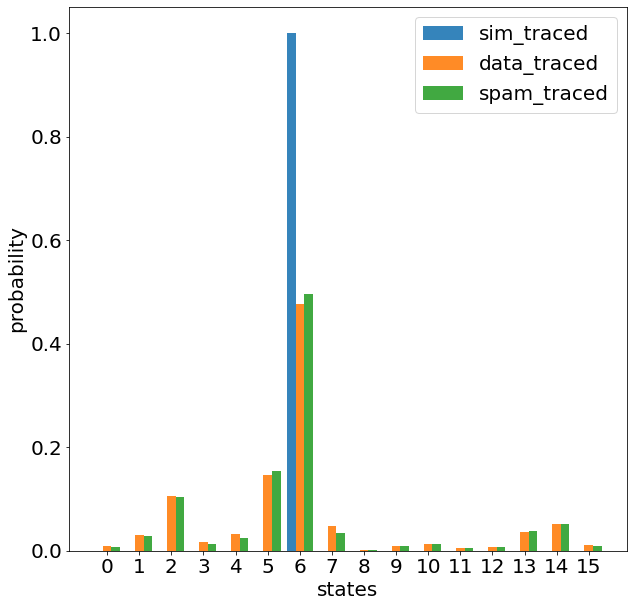

2023-04-26-164925_Line_004.txt
HAD2:HAD3:CNOT25:CNOT34:SKAX1+1.0000:SKAY3+1.0000:XA230.2500+:SKAX2+1.0000:SKAX3+1.0000:XA230.2500+:AZ2+1.0000:SKAY3+1.0000:XA230.2500+:SKAX1+1.0000:AZ3+1.0000:XA230.2500+:SKAX2+1.0000:SKAX5+1.0000:SKAX4+1.0000:SKAX3+1.0000:XA230.2500+:SKAX2+1.0000:AZ3+1.0000:XA230.2500+:SKAY2+1.0000:SKAY3+1.0000:XA230.2500+:AZ2+1.0000:SKAX3+1.0000:XA230.2500+:AZ2+1.0000:SKAX3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



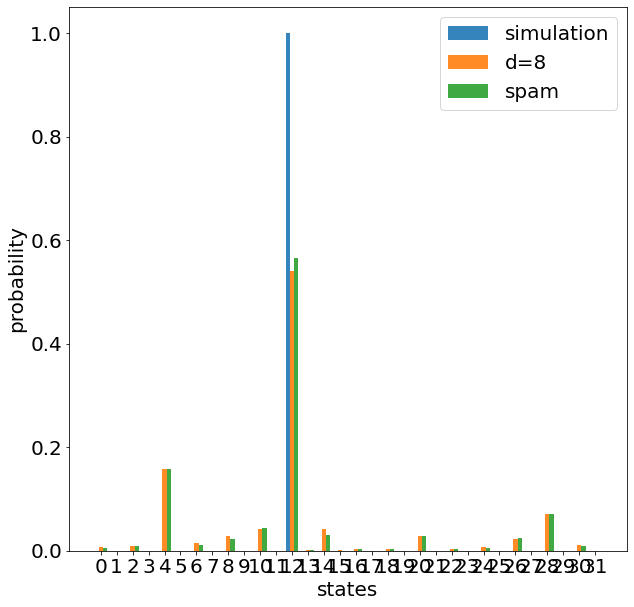

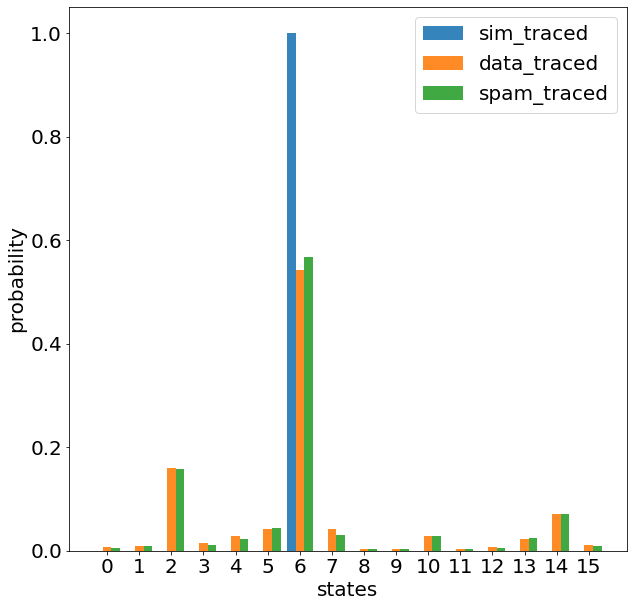

2023-04-26-165139_Line_005.txt
HAD2:HAD3:CNOT25:CNOT34:SKAY2+1.0000:AZ3+1.0000:XA230.2500+:AZ2+1.0000:SKAY3+1.0000:XA230.2500+:SKAX1+1.0000:AZ3+1.0000:XA230.2500+:SKAY2+1.0000:AZ3+1.0000:XA230.2500+:SKAY2+1.0000:SKAX5+1.0000:SKAX4+1.0000:SKAY3+1.0000:XA230.2500+:SKAY2+1.0000:SKAX3+1.0000:XA230.2500+:SKAX1+1.0000:SKAX3+1.0000:XA230.2500+:SKAX2+1.0000:SKAY3+1.0000:XA230.2500+:SKAX1+1.0000:SKAX3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



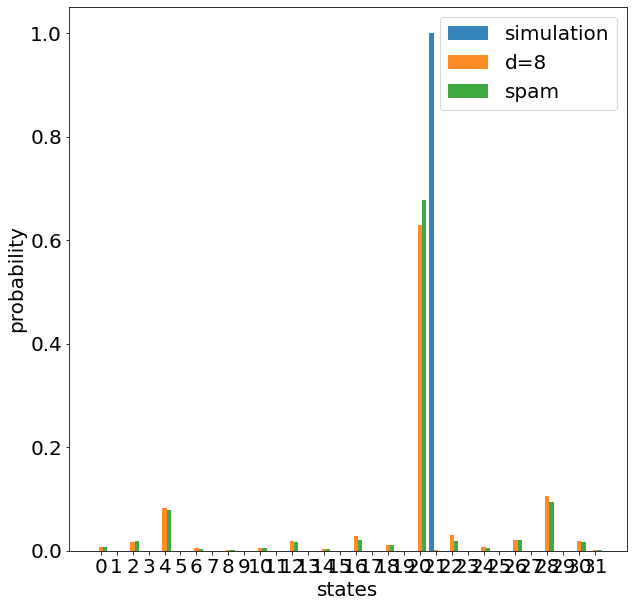

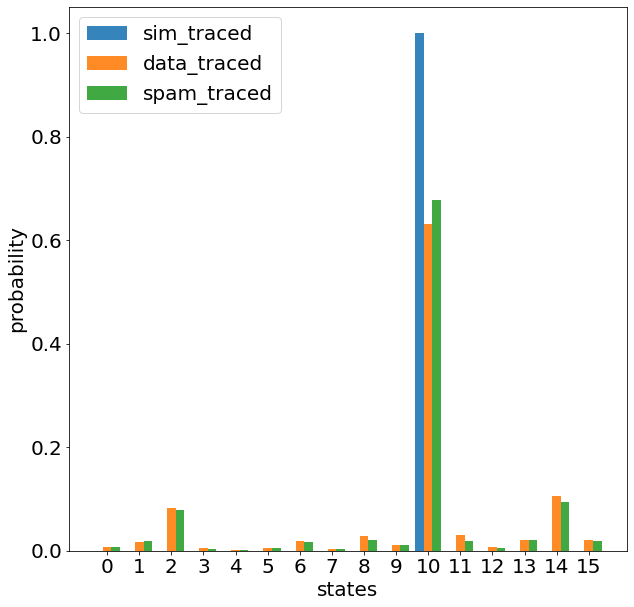

2023-04-26-165239_Line_006.txt
HAD2:HAD3:CNOT25:CNOT34:SKAX1+1.0000:SKAX3+1.0000:XA230.2500+:SKAY2+1.0000:SKAY3+1.0000:XA230.2500+:SKAX1+1.0000:AZ3+1.0000:XA230.2500+:SKAX2+1.0000:SKAY3+1.0000:XA230.2500+:SKAY2+1.0000:SKAX5+1.0000:SKAX4+1.0000:SKAX1+1.0000:XA230.2500+:SKAX2+1.0000:SKAX3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:SKAX2+1.0000:SKAX1+1.0000:XA230.2500+:AZ2+1.0000:SKAX3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



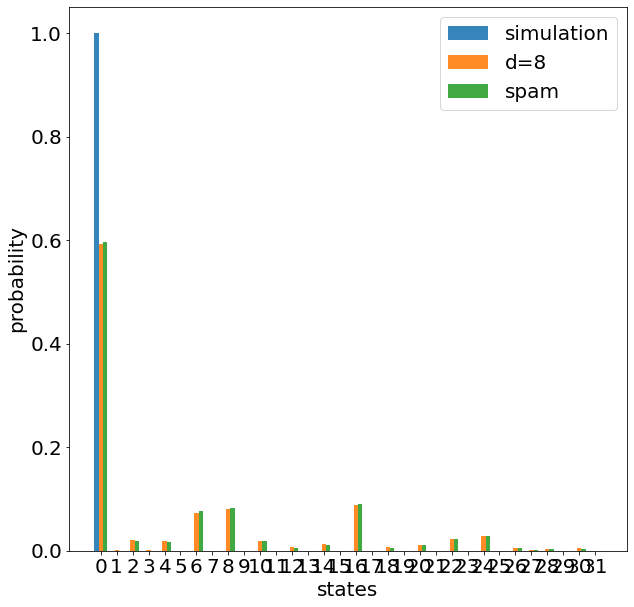

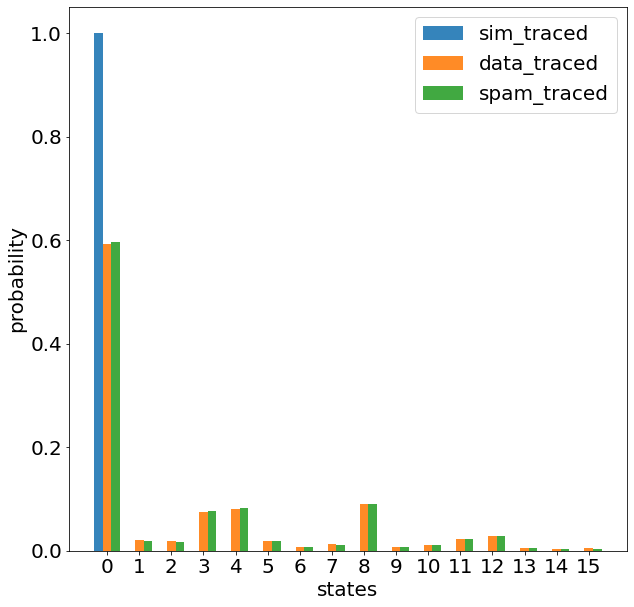

2023-04-26-170327_Line_007.txt
HAD2:HAD3:CNOT25:CNOT34:SKAX1+1.0000:SKAX1+1.0000:XA230.2500+:SKAY2+1.0000:SKAY3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:SKAY2+1.0000:SKAX1+1.0000:XA230.2500+:SKAX1+1.0000:SKAX5+1.0000:SKAX4+1.0000:SKAX3+1.0000:XA230.2500+:SKAX1+1.0000:SKAX3+1.0000:XA230.2500+:SKAY2+1.0000:SKAX1+1.0000:XA230.2500+:SKAY2+1.0000:SKAY3+1.0000:XA230.2500+:SKAX1+1.0000:SKAY3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



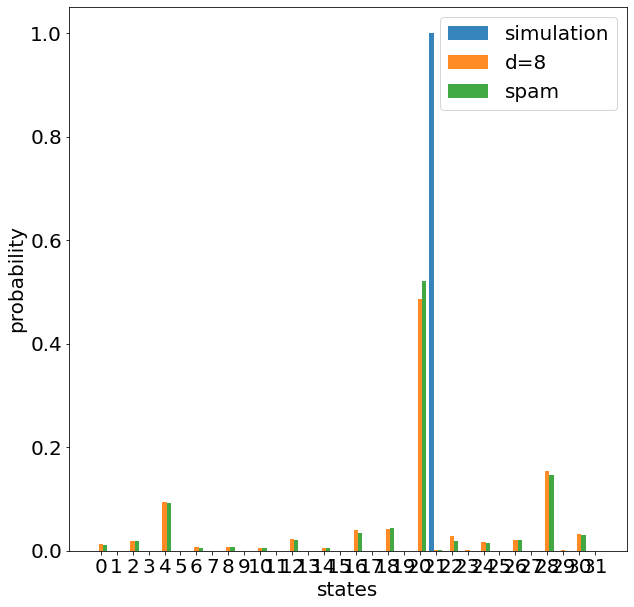

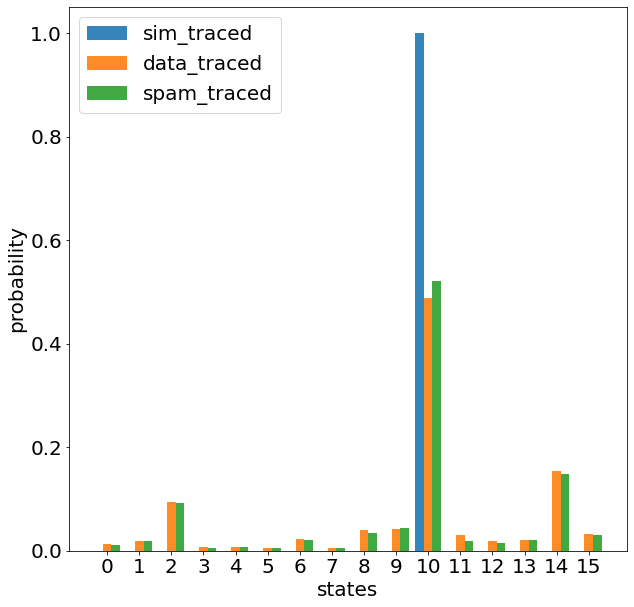

2023-04-26-170429_Line_008.txt
HAD2:HAD3:CNOT25:CNOT34:AZ2+1.0000:SKAX1+1.0000:XA230.2500+:AZ2+1.0000:SKAX3+1.0000:XA230.2500+:AZ2+1.0000:SKAX1+1.0000:XA230.2500+:SKAX1+1.0000:SKAX1+1.0000:XA230.2500+:SKAX2+1.0000:SKAX5+1.0000:SKAX4+1.0000:SKAX1+1.0000:XA230.2500+:SKAX1+1.0000:AZ3+1.0000:XA230.2500+:SKAY2+1.0000:SKAX3+1.0000:XA230.2500+:SKAX2+1.0000:SKAX3+1.0000:XA230.2500+:SKAX1+1.0000:SKAX3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



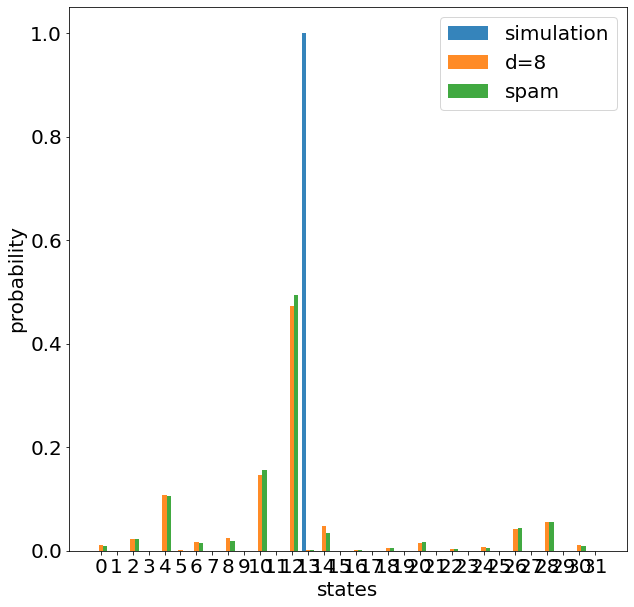

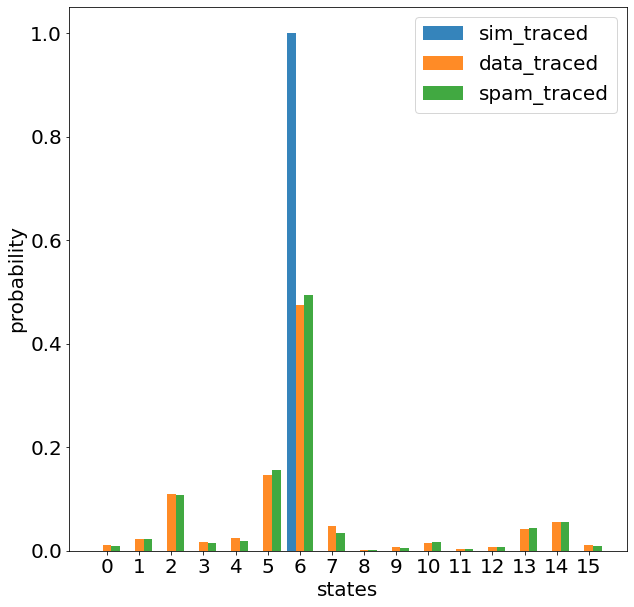

2023-04-26-170745_Line_009.txt
HAD2:HAD3:CNOT25:CNOT34:AZ2+1.0000:SKAX3+1.0000:XA230.2500+:SKAX2+1.0000:SKAX1+1.0000:XA230.2500+:SKAX1+1.0000:AZ3+1.0000:XA230.2500+:SKAX2+1.0000:SKAX3+1.0000:XA230.2500+:AZ2+1.0000:SKAX5+1.0000:SKAX4+1.0000:SKAX1+1.0000:XA230.2500+:SKAX1+1.0000:SKAX1+1.0000:XA230.2500+:AZ2+1.0000:SKAX3+1.0000:XA230.2500+:SKAX2+1.0000:SKAX1+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



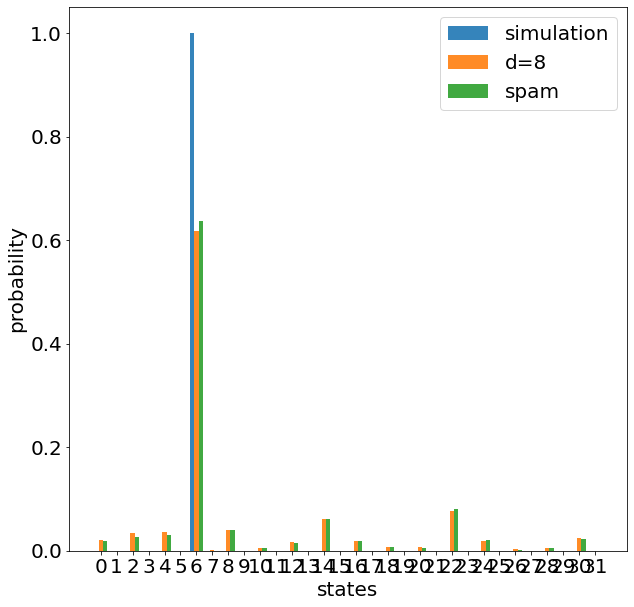

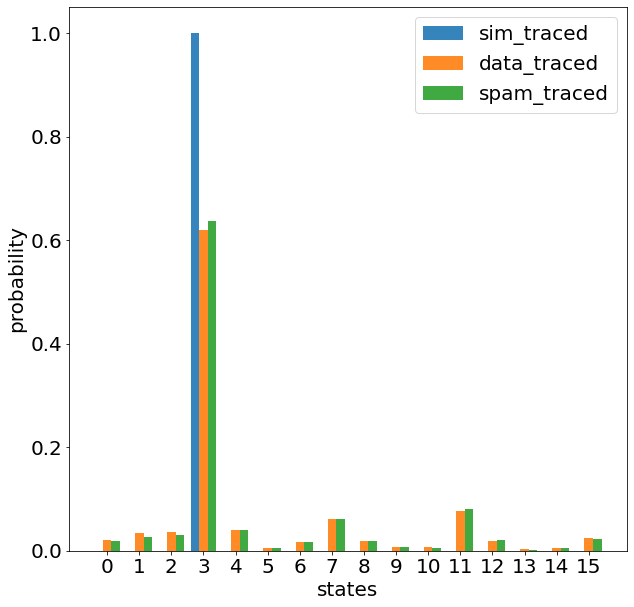

2023-04-26-170848_Line_010.txt
HAD2:HAD3:CNOT25:CNOT34:SKAX1+1.0000:SKAX1+1.0000:XA230.2500+:SKAX2+1.0000:SKAX1+1.0000:XA230.2500+:AZ2+1.0000:SKAX1+1.0000:XA230.2500+:SKAX1+1.0000:SKAX1+1.0000:XA230.2500+:AZ2+1.0000:SKAX5+1.0000:SKAX4+1.0000:SKAX1+1.0000:XA230.2500+:SKAX1+1.0000:SKAY3+1.0000:XA230.2500+:SKAX2+1.0000:SKAX3+1.0000:XA230.2500+:SKAX2+1.0000:SKAX3+1.0000:XA230.2500+:SKAX2+1.0000:SKAY3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2


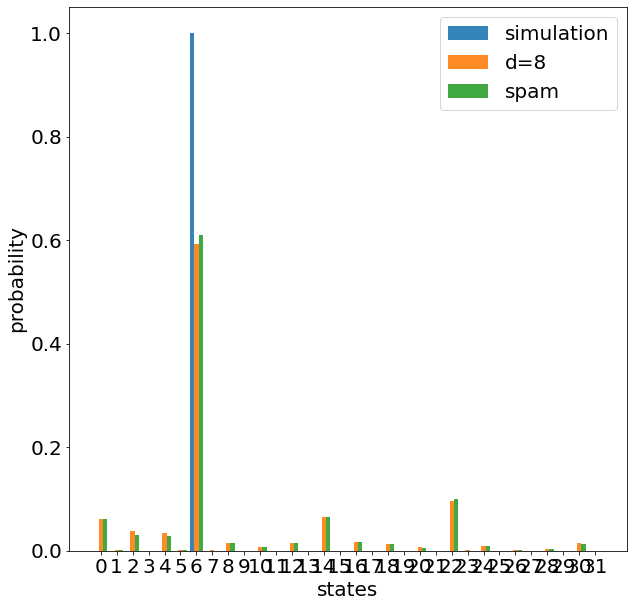

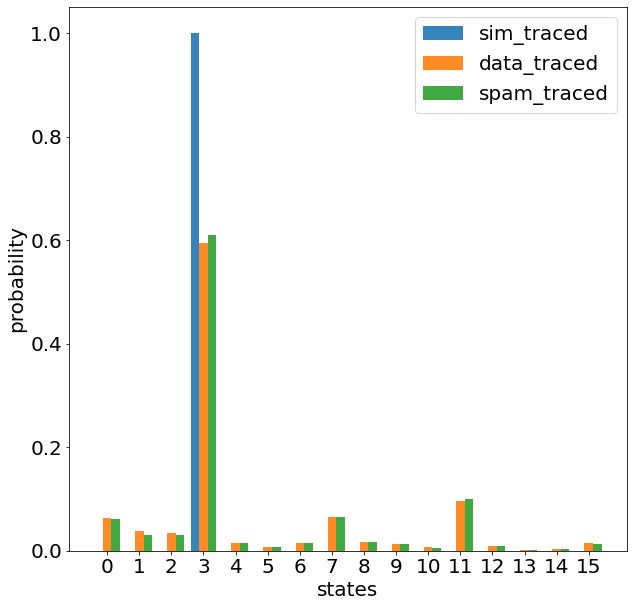

In [12]:
filenames_data=[]
counts_d8=[]
counts_d8_spam=[]
counts=[]
counts_spam=[]
filenames_data=filenames_d8.copy()
# print (filenames_data)
# # print (len(filenames_data))
paf_data=paf_data_d8
circuit=c_d8
for i in range (len(filenames_data)):
    print (filenames_data[i])
    a.Import(paf_data+filenames_data[i],keep_file=True)
    data_traced=Trace_Out(a,[0,1,2,3])
    counts=[round(shots*x) for x in  data_traced.population]
    counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping(counts,nqubit)
    counts_d8.append(counts_ibm_mapping_dic)
    
    a_s=spam2.Correct_SPAM(a)
    data_traced_spam=Trace_Out(a_s,[0,1,2,3])
    counts_spam=[round(shots*x) for x in  data_traced_spam.population]
    counts_ibm_mapping_spam, counts_ibm_mapping_dic_spam=map_statepop_2_ibm_mapping(counts_spam,nqubit)
    counts_d8_spam.append(counts_ibm_mapping_dic_spam)
    
    b_c.Interpret_GatesLab_Sequence(circuit[i])
    print (circuit[i])
    b=b_c.Simulate()
    sim_traced=Trace_Out(b,[0,1,2,3])
    Display_States_Population(states=[b,a,a_s],label=["simulation","d=8","spam"])
    Display_States_Population(states=[sim_traced,data_traced,data_traced_spam],label=["sim_traced","data_traced","spam_traced"])

In [13]:
# print (counts_d2[0])
# print (counts_d2_spam[0])

In [15]:
import copy
from copy import copy, deepcopy

# copy.copy(x)
# copy.deepcopy(x)

# picklefile="c39b72eb-9de9-4338-b6ae-e478130a3f4fXX23541withpadding_set2"
with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/circuits/23541 EAB XX C=10 0424  set2/c39b72eb-9de9-4338-b6ae-e478130a3f4fXX23541withpadding_set2", "rb") as fp:   # Unpickling
    eab_load = pickle.load(fp)
# print (picklefile)
# print (b)

# with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/circuits/23541 EAB XX C=10 0424 /"+picklefile, "rb") as fp:   # Unpickling
#     eab_load_2 = pickle.load(fp)
# print (picklefile)

# with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/circuits/23541 EAB XX C=10 0424 /"+picklefile, "rb") as fp:   # Unpickling
#     eab_load_3 = pickle.load(fp)
# print (picklefile)


C=10
eab_load_cpy=deepcopy(eab_load)
eab_load_cpy_spam=deepcopy(eab_load)
eab_load_cpy_24=deepcopy(eab_load[0:20]) #a copy that only has depth=[2,4]


In [16]:
for i in range (C):
#     print (i)
    assert eab_load_cpy[i]["L"]==2
    eab_load_cpy[i]["counts"]=counts_d2[i].copy()


    
for i in range (C):
#     print (i)
    assert eab_load_cpy_spam[i]["L"]==2
    eab_load_cpy_spam[i]["counts"]=counts_d2_spam[i].copy()



for i in range (C):
    print (eab_load_cpy[i]["counts"])
    print (eab_load_cpy_spam[i]["counts"])

{'0000': 77, '1000': 2931, '0100': 158, '1100': 100, '0010': 84, '1010': 206, '0110': 18, '1110': 21, '0001': 10, '1001': 195, '0101': 94, '1101': 44, '0011': 5, '1011': 32, '0111': 14, '1111': 11}
{'0000': 41, '1000': 2988, '0100': 160, '1100': 87, '0010': 84, '1010': 211, '0110': 16, '1110': 14, '0001': 7, '1001': 196, '0101': 99, '1101': 44, '0011': 4, '1011': 29, '0111': 12, '1111': 9}
{'0000': 257, '1000': 9, '0100': 34, '1100': 79, '0010': 24, '1010': 13, '0110': 6, '1110': 25, '0001': 2977, '1001': 49, '0101': 61, '1101': 105, '0011': 246, '1011': 78, '0111': 4, '1111': 33}
{'0000': 223, '1000': 7, '0100': 33, '1100': 80, '0010': 22, '1010': 13, '0110': 5, '1110': 25, '0001': 3076, '1001': 40, '0101': 56, '1101': 110, '0011': 198, '1011': 82, '0111': 0, '1111': 29}
{'0000': 16, '1000': 60, '0100': 35, '1100': 10, '0010': 20, '1010': 512, '0110': 73, '1110': 51, '0001': 45, '1001': 142, '0101': 30, '1101': 14, '0011': 53, '1011': 2721, '0111': 91, '1111': 127}
{'0000': 14, '1000'

In [17]:
for i in range (C,2*C):
#     print (i)
    assert eab_load_cpy[i]["L"]==4
    eab_load_cpy[i]["counts"]=counts_d4[i-10].copy()
#     print ( eab_load_cpy[i]["counts_exp"])
#     print (eab_load_cpy[i]["counts"])
    
for i in range (C,2*C):
#     print (i)
    assert eab_load_cpy_spam[i]["L"]==4
    eab_load_cpy_spam[i]["counts"]=counts_d4_spam[i-10].copy()
#     print ( eab_load_cpy[i]["counts_exp"])
#     print (eab_load_cpy_spam[i]["counts"])

for i in range (C,2*C):
    print (eab_load_cpy[i]["counts"])
    print (eab_load_cpy_spam[i]["counts"])    

{'0000': 2608, '1000': 51, '0100': 44, '1100': 95, '0010': 303, '1010': 43, '0110': 9, '1110': 45, '0001': 429, '1001': 17, '0101': 34, '1101': 46, '0011': 190, '1011': 26, '0111': 11, '1111': 49}
{'0000': 2622, '1000': 43, '0100': 38, '1100': 97, '0010': 306, '1010': 44, '0110': 1, '1110': 45, '0001': 435, '1001': 16, '0101': 35, '1101': 48, '0011': 189, '1011': 27, '0111': 6, '1111': 49}
{'0000': 27, '1000': 801, '0100': 51, '1100': 52, '0010': 26, '1010': 152, '0110': 20, '1110': 15, '0001': 80, '1001': 2319, '0101': 37, '1101': 106, '0011': 53, '1011': 208, '0111': 38, '1111': 15}
{'0000': 16, '1000': 789, '0100': 51, '1100': 48, '0010': 24, '1010': 157, '0110': 20, '1110': 10, '0001': 55, '1001': 2420, '0101': 38, '1101': 102, '0011': 51, '1011': 176, '0111': 37, '1111': 6}
{'0000': 15, '1000': 10, '0100': 187, '1100': 7, '0010': 45, '1010': 31, '0110': 576, '1110': 39, '0001': 16, '1001': 18, '0101': 435, '1101': 50, '0011': 66, '1011': 172, '0111': 2193, '1111': 140}
{'0000': 12

In [18]:
for i in range (2*C,3*C):
#     print (i)
    assert eab_load_cpy[i]["L"]==8
    eab_load_cpy[i]["counts"]=counts_d8[i-20].copy()
#     print ( eab_load_cpy[i]["counts_exp"])
#     print (eab_load_cpy[i])

for i in range (2*C,3*C):
#     print (i)
    assert eab_load_cpy_spam[i]["L"]==8
    eab_load_cpy_spam[i]["counts"]=counts_d8_spam[i-20].copy()
#     print ( eab_load_cpy[i]["counts_exp"])
#     print (eab_load_cpy_spam[i]["counts"])

for i in range (2*C,3*C):
    print (eab_load_cpy[i]["counts"])
    print (eab_load_cpy_spam[i]["counts"])    

{'0000': 21, '1000': 328, '0100': 121, '1100': 48, '0010': 20, '1010': 33, '0110': 39, '1110': 7, '0001': 112, '1001': 2609, '0101': 78, '1101': 144, '0011': 96, '1011': 279, '0111': 44, '1111': 21}
{'0000': 14, '1000': 304, '0100': 123, '1100': 43, '0010': 19, '1010': 31, '0110': 39, '1110': 5, '0001': 84, '1001': 2727, '0101': 81, '1101': 140, '0011': 94, '1011': 244, '0111': 41, '1111': 9}
{'0000': 353, '1000': 23, '0100': 36, '1100': 66, '0010': 216, '1010': 17, '0110': 14, '1110': 14, '0001': 2317, '1001': 87, '0101': 90, '1101': 33, '0011': 541, '1011': 99, '0111': 40, '1111': 54}
{'0000': 325, '1000': 21, '0100': 35, '1100': 67, '0010': 218, '1010': 16, '0110': 9, '1110': 13, '0001': 2390, '1001': 83, '0101': 90, '1101': 32, '0011': 518, '1011': 102, '0111': 27, '1111': 52}
{'0000': 38, '1000': 121, '0100': 423, '1100': 65, '0010': 126, '1010': 584, '0110': 1904, '1110': 190, '0001': 6, '1001': 34, '0101': 53, '1101': 22, '0011': 30, '1011': 148, '0111': 209, '1111': 47}
{'0000'

In [19]:
for i in range (C):
    assert eab_load_cpy_24[i]["L"]==2
    eab_load_cpy_24[i]["counts"]=counts_d2[i].copy()

for i in range (C,2*C):
    assert eab_load_cpy_24[i]["L"]==4
    eab_load_cpy_24[i]["counts"]=counts_d4[i-10].copy()

print (eab_load_cpy_24) 

[{'n': 2, 'L': 2, 'clifford': {'stabilizer': ['+IZ', '-ZI'], 'destabilizer': ['+IX', '+XI']}, 'clifford_layer': 'XX', 'circuit': 'HAD2:HAD3:CNOT25:CNOT34:SKAY2+1.0000:AZ3+1.0000:XA230.2500+:SKAX1+1.0000:SKAX5+1.0000:SKAX4+1.0000:SKAX3+1.0000:XA230.2500+:AZ2+1.0000:SKAY3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2', 'counts': {'0000': 77, '1000': 2931, '0100': 158, '1100': 100, '0010': 84, '1010': 206, '0110': 18, '1110': 21, '0001': 10, '1001': 195, '0101': 94, '1101': 44, '0011': 5, '1011': 32, '0111': 14, '1111': 11}}, {'n': 2, 'L': 2, 'clifford': {'stabilizer': ['+IZ', '+ZI'], 'destabilizer': ['-IX', '+XI']}, 'clifford_layer': 'XX', 'circuit': 'HAD2:HAD3:CNOT25:CNOT34:SKAX2+1.0000:SKAX1+1.0000:XA230.2500+:AZ2+1.0000:SKAX5+1.0000:SKAX4+1.0000:SKAY3+1.0000:XA230.2500+:SKAX1+1.0000:AZ3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2', 'counts': {'0000': 257, '1000': 9, '0100': 34, '1100': 79, '0010': 24, '1010': 13, '0110': 6, '1110': 25, '0001': 2977, '1001': 49,

In [20]:
eab_load_cpy_24_spam=deepcopy(eab_load[0:20]) #a copy that only has depth=[2,4]
for i in range (C):
    assert eab_load_cpy_24_spam[i]["L"]==2
    eab_load_cpy_24_spam[i]["counts"]=counts_d2_spam[i].copy()

for i in range (C,2*C):
    assert eab_load_cpy_24_spam[i]["L"]==4
    eab_load_cpy_24_spam[i]["counts"]=counts_d4_spam[i-10].copy()

print (eab_load_cpy_24_spam) 

[{'n': 2, 'L': 2, 'clifford': {'stabilizer': ['+IZ', '-ZI'], 'destabilizer': ['+IX', '+XI']}, 'clifford_layer': 'XX', 'circuit': 'HAD2:HAD3:CNOT25:CNOT34:SKAY2+1.0000:AZ3+1.0000:XA230.2500+:SKAX1+1.0000:SKAX5+1.0000:SKAX4+1.0000:SKAX3+1.0000:XA230.2500+:AZ2+1.0000:SKAY3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2', 'counts': {'0000': 41, '1000': 2988, '0100': 160, '1100': 87, '0010': 84, '1010': 211, '0110': 16, '1110': 14, '0001': 7, '1001': 196, '0101': 99, '1101': 44, '0011': 4, '1011': 29, '0111': 12, '1111': 9}}, {'n': 2, 'L': 2, 'clifford': {'stabilizer': ['+IZ', '+ZI'], 'destabilizer': ['-IX', '+XI']}, 'clifford_layer': 'XX', 'circuit': 'HAD2:HAD3:CNOT25:CNOT34:SKAX2+1.0000:SKAX1+1.0000:XA230.2500+:AZ2+1.0000:SKAX5+1.0000:SKAX4+1.0000:SKAY3+1.0000:XA230.2500+:SKAX1+1.0000:AZ3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2', 'counts': {'0000': 223, '1000': 7, '0100': 33, '1100': 80, '0010': 22, '1010': 13, '0110': 5, '1110': 25, '0001': 3076, '1001': 40, '0

In [21]:
sys.path.append(r"/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation")
import EAB_process_modified 
import itertools
import pdb

'''Specify a set of Pauli you want to estimate'''
# C=10
depth=[2,4,8]
pauli_request_list = [''.join(s) for s in itertools.product(['I','X','Y','Z'], repeat = nqubit)] #full

#process_EAB(Lrange, cb_data, pauli_request_list)
eab_result=EAB_process_modified.process_EAB(depth, eab_load_cpy, pauli_request_list)
# eab_result_spam=EAB_process_modified.process_EAB(depth, eab_load_cpy_spam, pauli_request_list)

print (eab_result)


{'fidelity_list': {'II': {2: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 4: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 8: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}, 'IX': {2: [0.7975, 0.7765, 0.6115, 0.729, 0.632, 0.762, 0.644, 0.5605, 0.701, 0.537], 4: [0.599, 0.428, 0.545, 0.4815, 0.5365, 0.5285, 0.619, 0.5845, 0.599, 0.5625], 8: [0.6915, 0.6305, 0.7255, 0.697, 0.713, 0.6535, 0.65, 0.7075, 0.6725, 0.6715]}, 'IY': {2: [0.7305, 0.747, 0.565, 0.702, 0.586, 0.7115, 0.623, 0.46, 0.6985, 0.5285], 4: [0.5725, 0.399, 0.4595, 0.347, 0.461, 0.458, 0.2855, 0.544, 0.5435, 0.4685], 8: [0.6555, 0.587, 0.4, 0.595, 0.6455, 0.5115, 0.4985, 0.4145, 0.5685, 0.5055]}, 'IZ': {2: [0.77, 0.8265, 0.7845, 0.861, 0.883, 0.7465, 0.893, 0.7925, 0.8885, 0.8825], 4: [0.8335, 0.833, 0.8135, 0.6275, 0.7795, 0.7705, 0.5095, 0.8615, 0.8555, 0.825], 8: [0.749, 0.8265, 0.4565, 0.75, 0.8015, 0.689, 0.6695, 0.469, 0.7, 0.665]}, 'XI': {2: [0.8045, 0.7855, 0.824, 0.8035, 0.8035, 0.8075, 0.8765, 0

In [22]:
depth=[2,4,8]
eab_result_spam=EAB_process_modified.process_EAB(depth, eab_load_cpy_spam, pauli_request_list)
# print (eab_result_spam)

depth=[2,4]
eab_result_24=EAB_process_modified.process_EAB(depth, eab_load_cpy_24, pauli_request_list)
print (eab_result_24)

depth=[2,4]
eab_result_24_spam=EAB_process_modified.process_EAB(depth, eab_load_cpy_24_spam, pauli_request_list)

{'fidelity_list': {'II': {2: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 4: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}, 'IX': {2: [0.7975, 0.7765, 0.6115, 0.729, 0.632, 0.762, 0.644, 0.5605, 0.701, 0.537], 4: [0.599, 0.428, 0.545, 0.4815, 0.5365, 0.5285, 0.619, 0.5845, 0.599, 0.5625]}, 'IY': {2: [0.7305, 0.747, 0.565, 0.702, 0.586, 0.7115, 0.623, 0.46, 0.6985, 0.5285], 4: [0.5725, 0.399, 0.4595, 0.347, 0.461, 0.458, 0.2855, 0.544, 0.5435, 0.4685]}, 'IZ': {2: [0.77, 0.8265, 0.7845, 0.861, 0.883, 0.7465, 0.893, 0.7925, 0.8885, 0.8825], 4: [0.8335, 0.833, 0.8135, 0.6275, 0.7795, 0.7705, 0.5095, 0.8615, 0.8555, 0.825]}, 'XI': {2: [0.8045, 0.7855, 0.824, 0.8035, 0.8035, 0.8075, 0.8765, 0.822, 0.737, 0.7395], 4: [0.662, 0.7365, 0.631, 0.551, 0.622, 0.6065, 0.7775, 0.691, 0.647, 0.8425]}, 'XX': {2: [0.664, 0.63, 0.5565, 0.6315, 0.5465, 0.6445, 0.5765, 0.4925, 0.553, 0.4725], 4: [0.537, 0.3775, 0.395, 0.4245, 0.4445, 0.445, 0.5305, 0.4915, 0.505, 0.522]}, 'XY': {2: [0.611, 0.6

In [23]:
raw_fidelity_list = eab_result["fidelity_list"]
plot_dic={}
err=[]
# sys.exit(0)
depth=[2,4,8]
fidelity_list = {}
stdev_list = {}

for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        fidelity_list[pauli_label] = 1.0
        stdev_list[pauli_label] = 0.0
    else:
        alpha, alpha_err = EAB_process_modified.fit_EAB(depth, raw_fidelity_list[pauli_label])
        fidelity_list[pauli_label] = alpha
        stdev_list[pauli_label] = alpha_err

# print(fidelity_list)

# print(stdev_list)

print("Parameters: n = %d, C = %d, " % (nqubit,C), "L = ", str(depth))
use_density_matrix=False
use_readout_error =False
shots=2000
if use_density_matrix:
    print("Density matrix based simulation")
else:
    print("Measurement based simulation, shots = %d" % shots)

if use_readout_error is True:
    print("Measurement bitflip rate = %f" % eps_readout)
else:
    print("No readout error")

# Average fidelity
print("Total error = ", 1-np.mean(list(fidelity_list.values())))

print("Label / Pauli infidelity / Standard deviation")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], 1-fidelity_list[pauli_label], stdev_list[pauli_label])
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))
    plot_dic[pauli_label[::-1]]=1-fidelity_list[pauli_label]
    err.append(stdev_list[pauli_label])
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))

plot_c10={}
plot_c10=plot_dic
err_c10=err.copy()



Parameters: n = 2, C = 10,  L =  [2, 4, 8]
Measurement based simulation, shots = 2000
No readout error
Total error =  0.03896819746353608
Label / Pauli infidelity / Standard deviation
II 0.0 0.0
XI -0.027450160655130063 0.006594743591364598
YI 0.018335841254290886 0.012410279827227587
ZI 0.034210207312767804 0.009690560194333817
IX 0.04624720715133901 0.0076455624449686165
XX 0.041814128724260935 0.011021704963361406
YX 0.07248127214115507 0.015979465826672094
ZX 0.07689464565971227 0.014079945369816093
IY 0.0825478328276199 0.015675277939732998
XY 0.0766935266844041 0.01655132787263551
YY 0.054350165899018754 0.011534883606989952
ZY 0.06154103350478268 0.007733880050604847
IZ 0.03979175525156953 0.010614146386371787
XZ 0.02809151635063234 0.0123184050428247
YZ -0.00041645243841470503 0.0069935567220202
ZZ 0.018358639748569106 0.00263288949283532


In [24]:
error_list = fidelity_to_error(fidelity_list,nqubit)
print("Label / Pauli error rates")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], error_list[pauli_label])


Label / Pauli error rates
II 0.9610318025364639
XI 0.003001221671699153
YI -0.0001990052972862047
ZI -0.005980717718508943
IX 0.006151554764986647
XX 0.014662627221732907
YX -0.001250432140860555
ZX -0.000540654613896345
IY 0.0014396416100668635
XY 0.0015795344675466477
YY -0.0010808988444769227
ZY -0.0010654948393144098
IZ 0.02510302911050051
XZ 0.0007556689445685355
YZ -0.00036361236653961043
ZZ -0.003244264506682068


In [25]:
raw_fidelity_list = eab_result_spam["fidelity_list"]
plot_dic={}
err=[]
# sys.exit(0)
depth=[2,4,8]
fidelity_list = {}
stdev_list = {}

for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        fidelity_list[pauli_label] = 1.0
        stdev_list[pauli_label] = 0.0
    else:
        alpha, alpha_err = EAB_process_modified.fit_EAB(depth, raw_fidelity_list[pauli_label])
        fidelity_list[pauli_label] = alpha
        stdev_list[pauli_label] = alpha_err

# print(fidelity_list)

# print(stdev_list)

print("Parameters: n = %d, C = %d, " % (nqubit,C), "L = ", str(depth))
use_density_matrix=False
use_readout_error =False
shots=2000
if use_density_matrix:
    print("Density matrix based simulation")
else:
    print("Measurement based simulation, shots = %d" % shots)

if use_readout_error is True:
    print("Measurement bitflip rate = %f" % eps_readout)
else:
    print("No readout error")

# Average fidelity
print("Total error = ", 1-np.mean(list(fidelity_list.values())))

print("Label / Pauli infidelity / Standard deviation")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], 1-fidelity_list[pauli_label], stdev_list[pauli_label])
    plot_dic[pauli_label[::-1]]=1-fidelity_list[pauli_label]
    err.append(stdev_list[pauli_label])
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))

plot_c10_spam={}
plot_c10_spam=plot_dic
err_c10_spam=err.copy()

Parameters: n = 2, C = 10,  L =  [2, 4, 8]
Measurement based simulation, shots = 2000
No readout error
Total error =  0.03781632619052078
Label / Pauli infidelity / Standard deviation
II 0.0 0.0
XI -0.028594326370810164 0.006510626180306547
YI 0.02146890924577627 0.012686271799146453
ZI 0.03481809038529937 0.00982862302297178
IX 0.0449200445649518 0.007316104814633831
XX 0.03728582318473339 0.010348885175548989
YX 0.07361825391227905 0.01606433353187097
ZX 0.07718528350002818 0.014703027360280209
IY 0.07976316288780194 0.015535730155393187
XY 0.07469345878339118 0.01656805046553506
YY 0.04920578442755863 0.010078711705059801
ZY 0.05771793949898252 0.007140465810700363
IZ 0.03783727366612599 0.01045468787250225
XZ 0.02784182640012034 0.012514071271624431
YZ 0.0003764349419688173 0.006698514451022694
ZZ 0.01692326002012501 0.002126329096240127


spam results

In [26]:
error_list = fidelity_to_error(fidelity_list,nqubit)
print("Label / Pauli error rates")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], error_list[pauli_label])


Label / Pauli error rates
II 0.9621836738094793
XI 0.0035979183009814536
YI -0.0005824067652870427
ZI -0.005829305624893588
IX 0.005228566387738512
XX 0.015586956157082013
YX -0.0018316353626825072
ZX -0.0008137891848940121
IY 0.0016821988332708232
XY 0.0010706352311727896
YY -0.0008929300177471997
ZY -0.0011113652108774158
IZ 0.023982392654445087
XZ 0.0009648218112352225
YZ -0.0005043141621050226
ZZ -0.0027314168569183145


In [27]:
raw_fidelity_list = eab_result_24["fidelity_list"]
plot_dic={}
err=[]
# sys.exit(0)
depth=[2,4]
fidelity_list = {}
stdev_list = {}

for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        fidelity_list[pauli_label] = 1.0
        stdev_list[pauli_label] = 0.0
    else:
        alpha, alpha_err = EAB_process_modified.fit_EAB(depth, raw_fidelity_list[pauli_label])
        fidelity_list[pauli_label] = alpha
        stdev_list[pauli_label] = alpha_err

# print(fidelity_list)

# print(stdev_list)

print("Parameters: n = %d, C = %d, " % (nqubit,C), "L = ", str(depth))
use_density_matrix=False
use_readout_error =False
shots=2000
if use_density_matrix:
    print("Density matrix based simulation")
else:
    print("Measurement based simulation, shots = %d" % shots)

if use_readout_error is True:
    print("Measurement bitflip rate = %f" % eps_readout)
else:
    print("No readout error")

# Average fidelity
print("Total error = ", 1-np.mean(list(fidelity_list.values())))

print("Label / Pauli infidelity / Standard deviation")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], 1-fidelity_list[pauli_label], stdev_list[pauli_label])
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))
    plot_dic[pauli_label[::-1]]=1-fidelity_list[pauli_label]
    err.append(stdev_list[pauli_label])
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))

plot_c10_24={}
plot_c10_24=plot_dic
err_c10_24=err.copy()



Parameters: n = 2, C = 10,  L =  [2, 4]
Measurement based simulation, shots = 2000
No readout error
Total error =  0.09641093967626202
Label / Pauli infidelity / Standard deviation
II 0.0 0.0
XI 0.09875084630744269 0.024640795962512608
YI 0.15471935413315063 0.03356847223534752
ZI 0.037881280529566186 0.024678218089969218
IX 0.0804864919304017 0.02012337786895582
XX 0.09992053522320932 0.02377996630031044
YX 0.15308541632949102 0.03556792190120347
ZX 0.10993476433259464 0.03321182682319422
IY 0.11775354388228876 0.03216139581435028
XY 0.15664854918627336 0.03426332992701156
YY 0.12025759163410699 0.025595658601398372
ZY 0.0966621051690556 0.019473510849618632
IZ 0.04061792365727701 0.022701651803872007
XZ 0.15323536251690706 0.031965328619481904
YZ 0.11002954031280854 0.02542060365478243
ZZ 0.01259172967561828 0.0061007574055210925


In [28]:
raw_fidelity_list = eab_result_24_spam["fidelity_list"]
plot_dic={}
err=[]
# sys.exit(0)
depth=[2,4]
fidelity_list = {}
stdev_list = {}

for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        fidelity_list[pauli_label] = 1.0
        stdev_list[pauli_label] = 0.0
    else:
        alpha, alpha_err = EAB_process_modified.fit_EAB(depth, raw_fidelity_list[pauli_label])
        fidelity_list[pauli_label] = alpha
        stdev_list[pauli_label] = alpha_err

# print(fidelity_list)

# print(stdev_list)

print("Parameters: n = %d, C = %d, " % (nqubit,C), "L = ", str(depth))
use_density_matrix=False
use_readout_error =False
shots=2000
if use_density_matrix:
    print("Density matrix based simulation")
else:
    print("Measurement based simulation, shots = %d" % shots)

if use_readout_error is True:
    print("Measurement bitflip rate = %f" % eps_readout)
else:
    print("No readout error")

# Average fidelity
print("Total error = ", 1-np.mean(list(fidelity_list.values())))

print("Label / Pauli infidelity / Standard deviation")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], 1-fidelity_list[pauli_label], stdev_list[pauli_label])
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))
    plot_dic[pauli_label[::-1]]=1-fidelity_list[pauli_label]
    err.append(stdev_list[pauli_label])
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))

plot_c10_24_spam={}
plot_c10_24_spam=plot_dic
err_c10_24_spam=err.copy()


Parameters: n = 2, C = 10,  L =  [2, 4]
Measurement based simulation, shots = 2000
No readout error
Total error =  0.0947256597543853
Label / Pauli infidelity / Standard deviation
II 0.0 0.0
XI 0.10038151986051591 0.024346421717114805
YI 0.1538816713371437 0.03220041883888443
ZI 0.03578293459195414 0.02331524289429148
IX 0.0810552086938533 0.020175570687758996
XX 0.10369950749560175 0.022457911526817417
YX 0.15408194870780412 0.03371557689434261
ZX 0.10807269198864322 0.03228395155818058
IY 0.11495756537806645 0.0318710655389655
XY 0.1566794467294349 0.03335704129486217
YY 0.11761543148581177 0.02274669819686065
ZY 0.09174671715300686 0.01930847569687036
IZ 0.03658877614103839 0.022686444112950996
XZ 0.15064554384564421 0.03135492904076954
YZ 0.10475562131242133 0.023624342360611027
ZZ 0.00566597134922564 0.005894316038627735


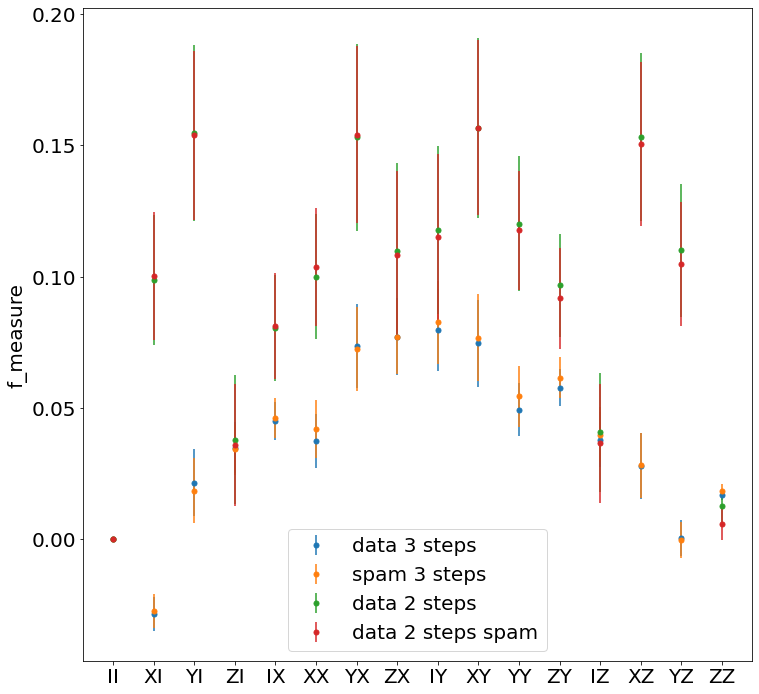

In [29]:
f=plt.figure(figsize=(12,12))
# plt.plot(list(plot_c10.keys()),list(plot_c10.values()),"*",markersize=10)
# plt.plot(list(plot_c10_spam.keys()),list(plot_c10_spam.values()),"*",markersize=10)

plt.errorbar(list(plot_c10_spam.keys()),list(plot_c10_spam.values()), yerr=err_c10_spam, fmt='o',markersize=5)
plt.errorbar(list(plot_c10.keys()),list(plot_c10.values()), yerr=err_c10, fmt='o',markersize=5)
plt.errorbar(list(plot_c10_24.keys()),list(plot_c10_24.values()), yerr=err_c10_24, fmt='o',markersize=5)
plt.errorbar(list(plot_c10_24_spam.keys()),list(plot_c10_24_spam.values()), yerr=err_c10_24_spam, fmt='o',markersize=5)

# plt.plot(list(plot_c20.keys()),list(plot_c20.values()),"*",markersize=10)
# plt.plot(list(plot_c10.keys()),list(plot_c10.values()),"*",markersize=10)
# plt.plot(list(plot_c5.keys()),list(plot_c5.values()),"*",markersize=10)
# plt.plot(list(plot_c3.keys()),list(plot_c3.values()),"*",markersize=10)
plt.legend(["data 3 steps","spam 3 steps","data 2 steps","data 2 steps spam"],fontsize=20)
plt.ylabel("f_measure",fontsize=20)
plt.savefig("XX EAB.pdf",format="pdf",dpi=500)

In [25]:
# True value for this specific noise model
# eps=0
# def f_true(P):
#     ans = 0.0
#     for Pi in P:
#         if Pi == 'Z' or Pi == 'Y':
#             ans += 2*eps
#     return ans
# def p_true(P):
#     if P == "XI" or P == "IX":
#         return eps
#     else:
#         return 0.0

# print("Label / True infidelity/ True Pauli error")
# for P in pauli_request_list:
#     print(P[::-1]," ",f_true(P)," ",p_true(P))

In [26]:
for i in range (4,-1,-1):
    print (i)

4
3
2
1
0
